<a href="https://colab.research.google.com/github/dho619/TCC_Pos_IA/blob/main/Algoritmo_RandonForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [98]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

In [99]:
#Para documentação de passo a passo e justificativa dessa função, pode encontrá-la no arquivo TratamentoDosDados.ipynb
def TratarDadosBaseWalmart(df):
  df.Date=pd.to_datetime(df.Date, format='%d-%m-%Y')
  df['Day'] = df.Date.dt.day
  df['Month'] = df.Date.dt.month
  df['Year'] = df.Date.dt.year
  df.drop(['Date'], axis=1, inplace=True)

  df.drop_duplicates(inplace=True)

  ignoreFeatures = ['Weekly_Sales', 'Day']
  maximumToBeCategorical = 45
  features = [i for i in df.columns if i not in ignoreFeatures]
  uniqueValuesForFeature = df[features].nunique().sort_values()
  categoricalFeature = [];
  valuesFeature = [];
  for i in range(df[features].shape[1]):
      if uniqueValuesForFeature.values[i]<=maximumToBeCategorical:
          categoricalFeature.append(uniqueValuesForFeature.index[i])
      else:
          valuesFeature.append(uniqueValuesForFeature.index[i])
  for i in categoricalFeature:
    if df[i].nunique()==2:
        df[i]=pd.get_dummies(df[i], drop_first=True, prefix=str(i))
    if (df[i].nunique()>2):
        df = pd.concat([df.drop([i], axis=1), pd.DataFrame(pd.get_dummies(df[i], prefix=str(i)))],axis=1)
    
  return df


In [100]:
#Para documentação de passo a passo e justificativa dessa função, pode encontrá-la no arquivo PreparaçãoDeDados.ipynb

def NormalizarValores(df, columns):
  for column in columns:
    df[column] = df[column]/df[column].max()

def PertenceAMesmaLoja(df, num1, num2):
  if num1 < 0 or num2 < 0: return False
  for i in range(1, 46):
    if df["Store_" + str(i)][num1] != df["Store_" + str(i)][num2]: return False
  return True

def PreparaDados(df, formatoDados):
  target = "Weekly_Sales"

  df["SalesOneWeekAgo"] = np.zeros(len(df[target]))
  df["SalesTwoWeeksAgo"] = np.zeros(len(df[target]))
  df["SalesThreeWeeksAgo"] = np.zeros(len(df[target]))

  for i, sales in enumerate(df[target]):
    df["SalesOneWeekAgo"][i] = df[target][i-1] if PertenceAMesmaLoja(df, i, i-1) else df[target][i]
    df["SalesTwoWeeksAgo"][i] = df[target][i-2] if PertenceAMesmaLoja(df, i, i-2) else df[target][i]
    df["SalesThreeWeeksAgo"][i] = df[target][i-3] if PertenceAMesmaLoja(df, i, i-3) else df[target][i]

  #Normalizando valores
  columns = ["Temperature", "Fuel_Price", "CPI", "Unemployment", "SalesOneWeekAgo", "SalesTwoWeeksAgo", "SalesThreeWeeksAgo"]
  NormalizarValores(df, columns)

  filtro_treino = df["Year_2012"] == 0
  filtro_teste = df["Year_2012"] == 1

  train = df.where(filtro_treino).dropna()
  test =  df.where(filtro_teste).dropna()

  y_train = train[target].array
  X_train = train.drop([target, "Year_2010", "Year_2011", "Year_2012"],axis=1)
  
  y_test = test[target].array
  X_test = test.drop([target, "Year_2010", "Year_2011", "Year_2012"],axis=1)

  X_train.reset_index(drop=True,inplace=True)

  return X_train.astype(formatoDados), X_test.astype(formatoDados), y_train.astype(formatoDados), y_test.astype(formatoDados)

In [101]:
df = pd.read_csv('./Walmart.csv')
df = TratarDadosBaseWalmart(df)

X_train, X_test, y_train, y_test = PreparaDados(df, np.float32)

print('Base original  ---> ',df.shape,df.shape,'\nBase de Treino  ---> ',X_train.shape,y_train.shape,'\nBase de teste   ---> ', X_test.shape,'', y_test.shape)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Base original  --->  (6435, 70) (6435, 70) 
Base de Treino  --->  (4500, 66) (4500,) 
Base de teste   --->  (1935, 66)  (1935,)


In [102]:
rf = RandomForestRegressor(min_samples_leaf=4)
rf.fit(X_train, y_train)

predictions = rf.predict(X_test)

In [103]:
r2_score(y_test, predictions), mean_absolute_error(y_test, predictions), np.sqrt(mean_squared_error(y_test, predictions))

(0.9772818271494956, 52384.95122816102, 80866.45056438734)

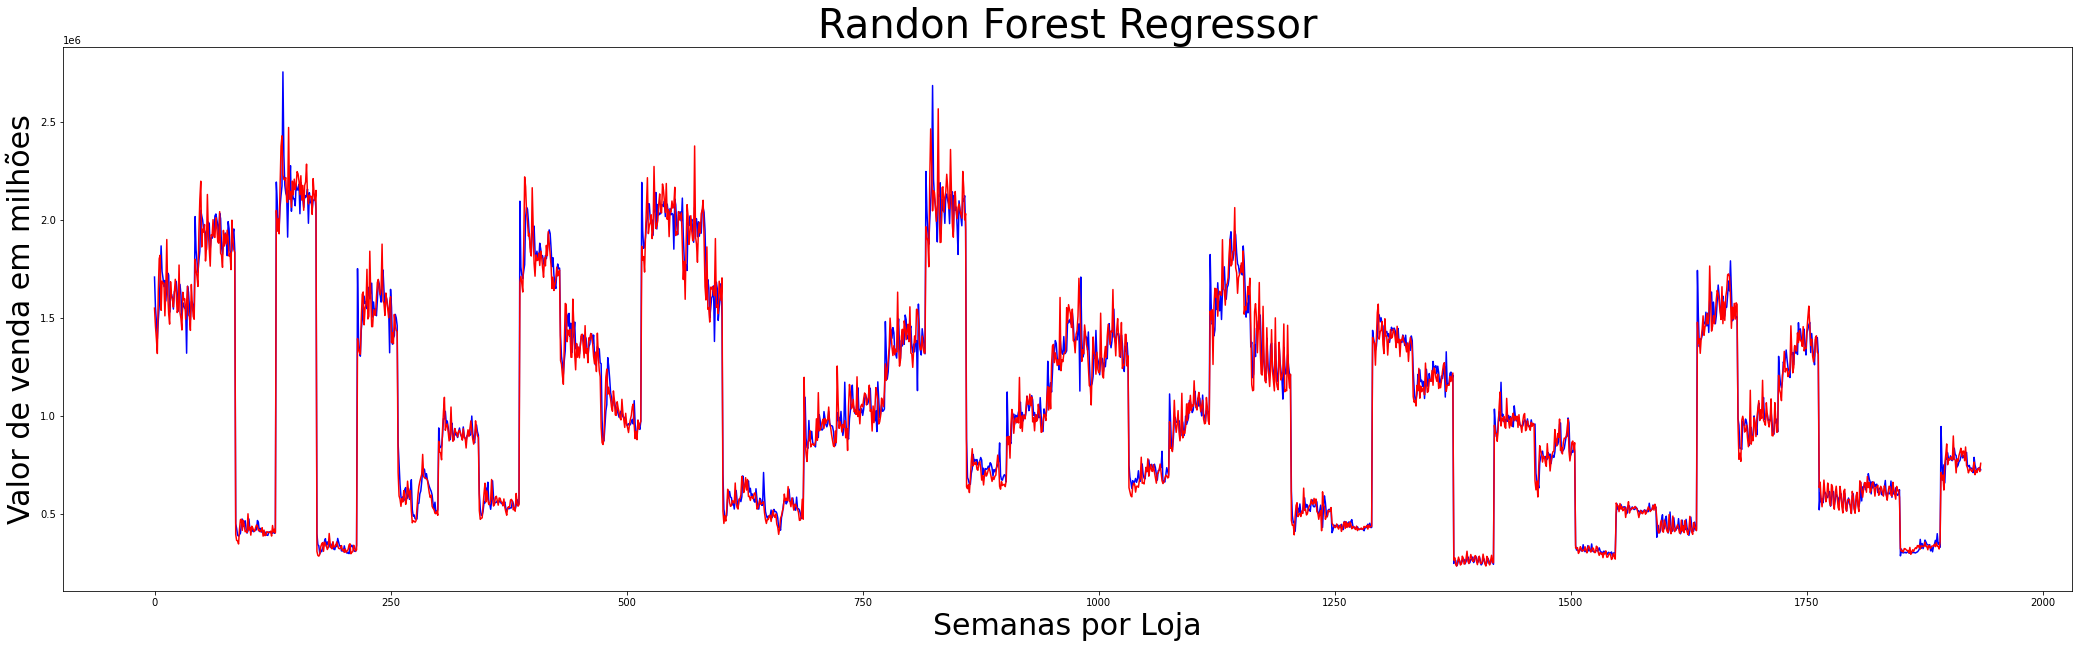

In [104]:
plt.figure(figsize = (36, 10)) 
plt.plot(range(len(predictions)), predictions, 'b')
plt.plot(range(len(predictions)), y_test, 'r')
plt.title("Randon Forest Regressor", fontsize=40)
plt.xlabel("Semanas por Loja", fontsize=30)
plt.ylabel("Valor de venda em milhões", fontsize=30)

plt.show() 

In [105]:
# for i in range(len(predictions)):
#   print("Valor real: {} Valor Predito: {}".format(y_test[i], predictions[i]))
  

In [106]:
# for i, feature in enumerate(rf.feature_names_in_):
#   print("Feature {}: {}".format(feature, rf.feature_importances_[i]))


Resultados Loja 1:
128502.17659883719 147041.45769977343


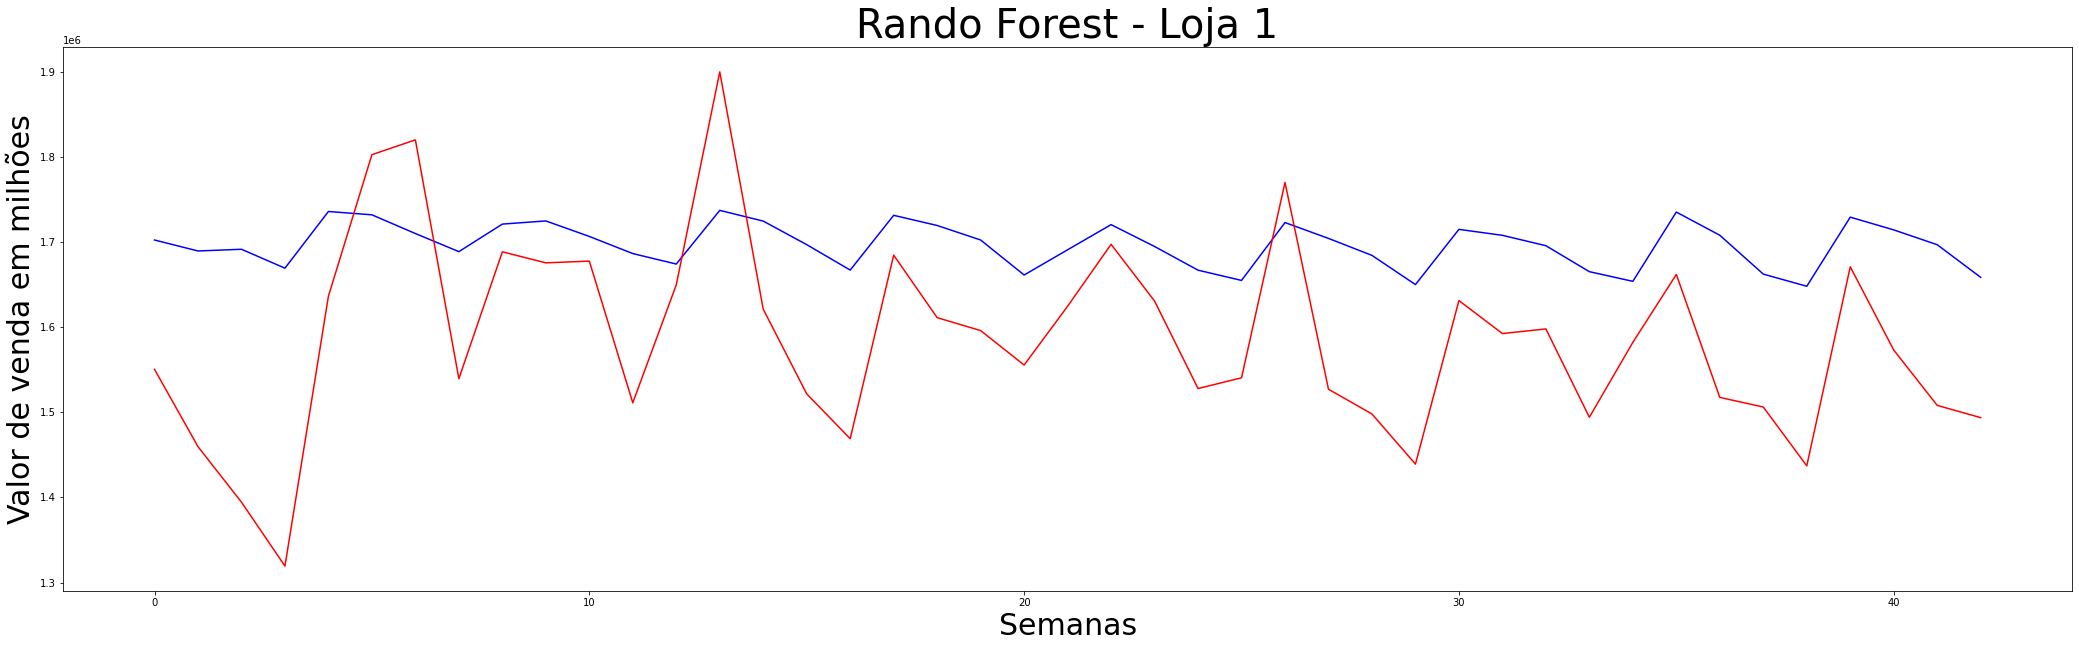

**************************************************
Resultados Loja 2:
270642.2776744185 286776.28186400916


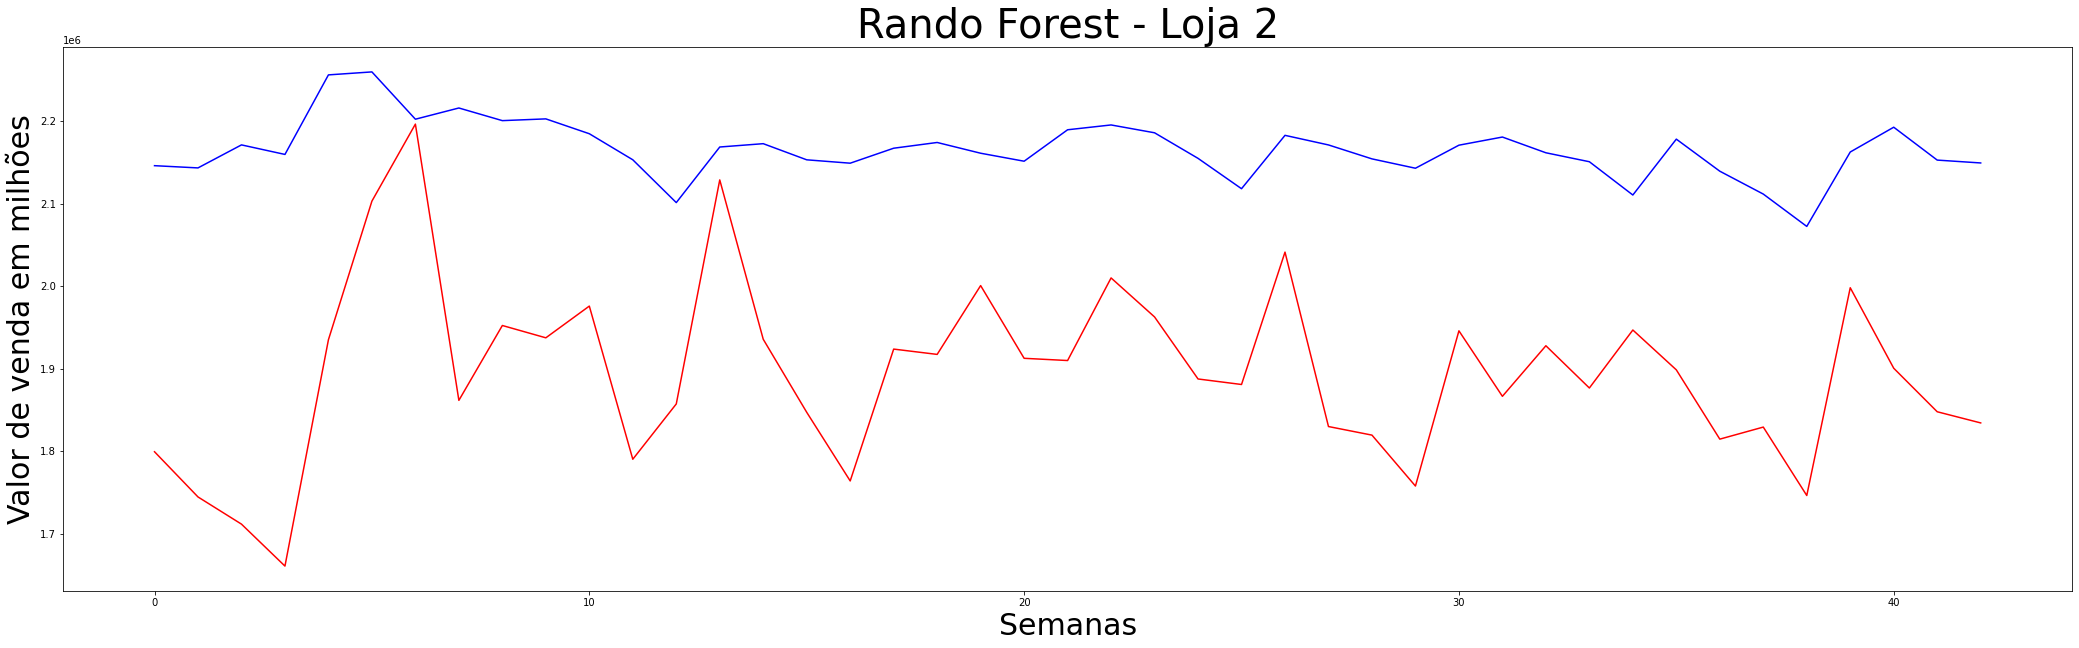

**************************************************
Resultados Loja 3:
175364.83926598835 179211.6520210402


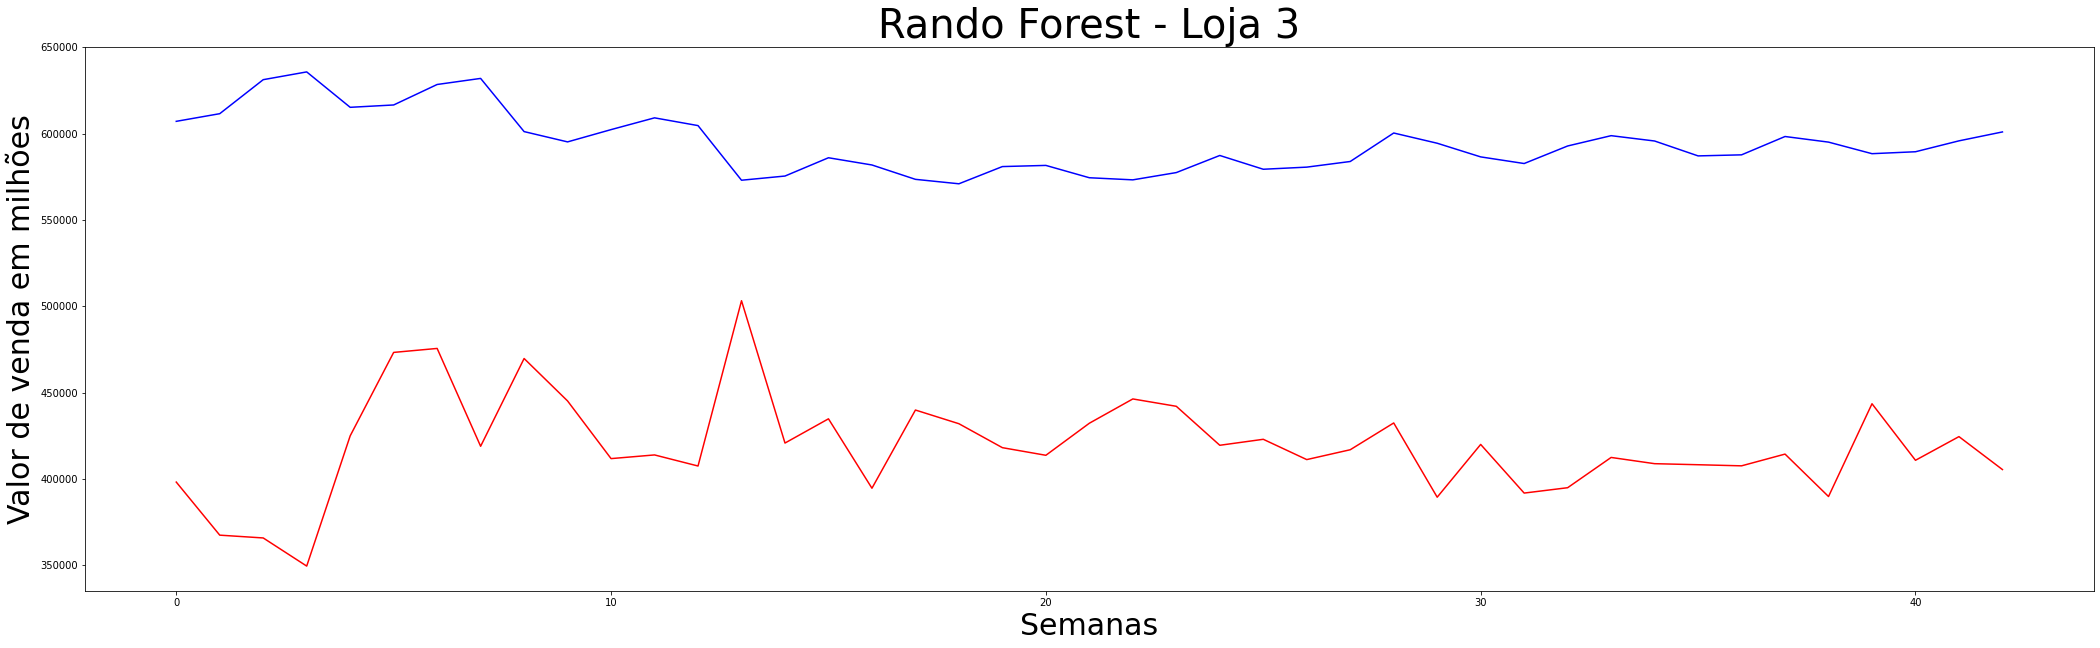

**************************************************
Resultados Loja 4:
382599.36186046514 396236.5778079936


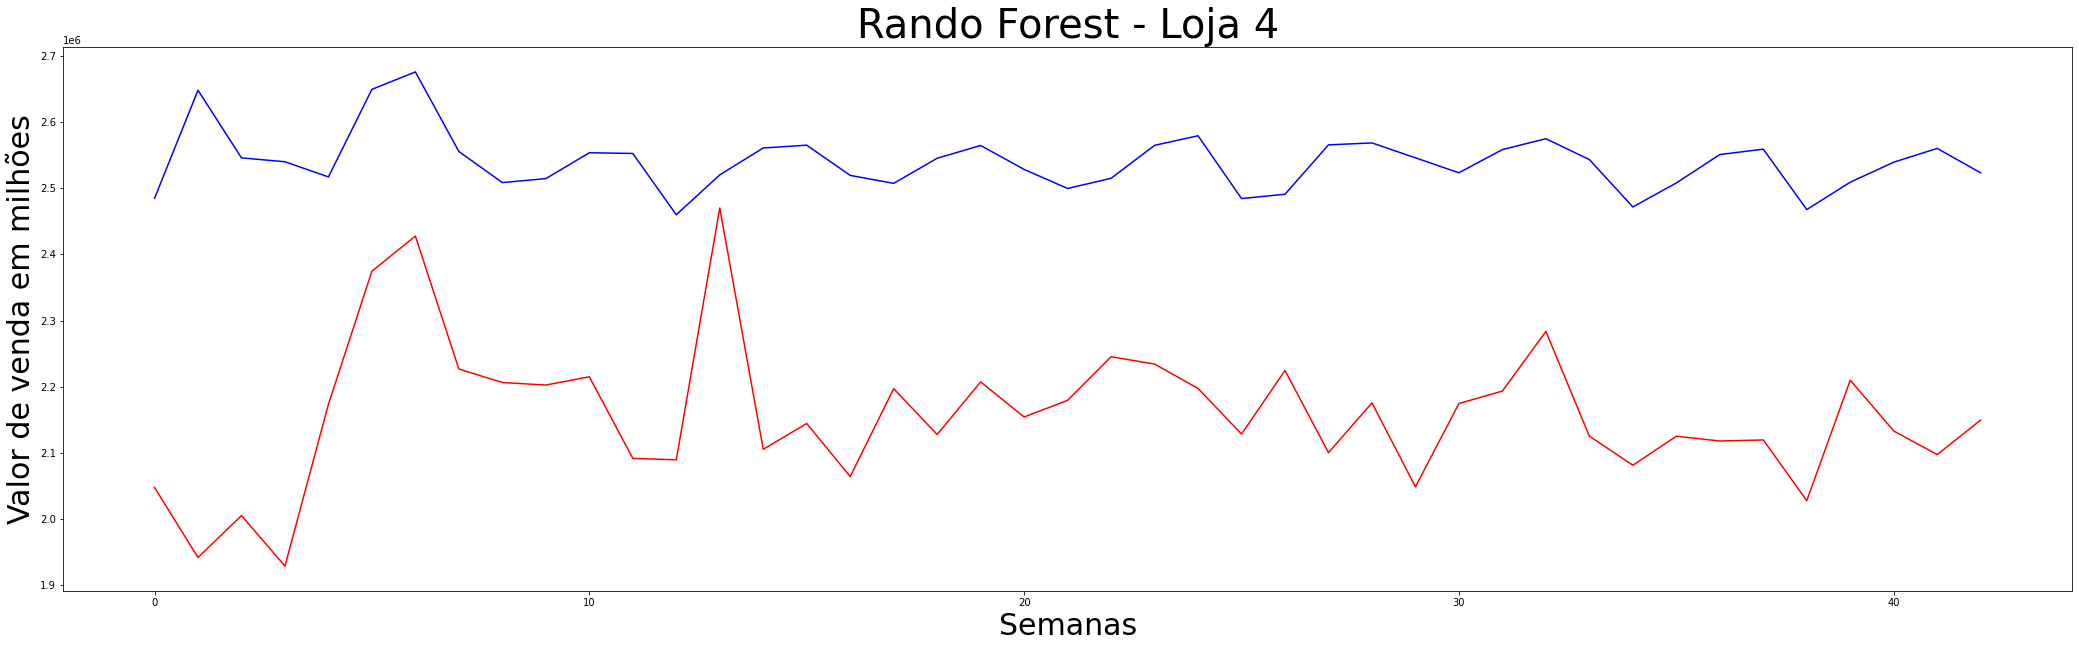

**************************************************
Resultados Loja 5:
56142.132449127916 59159.08193853574


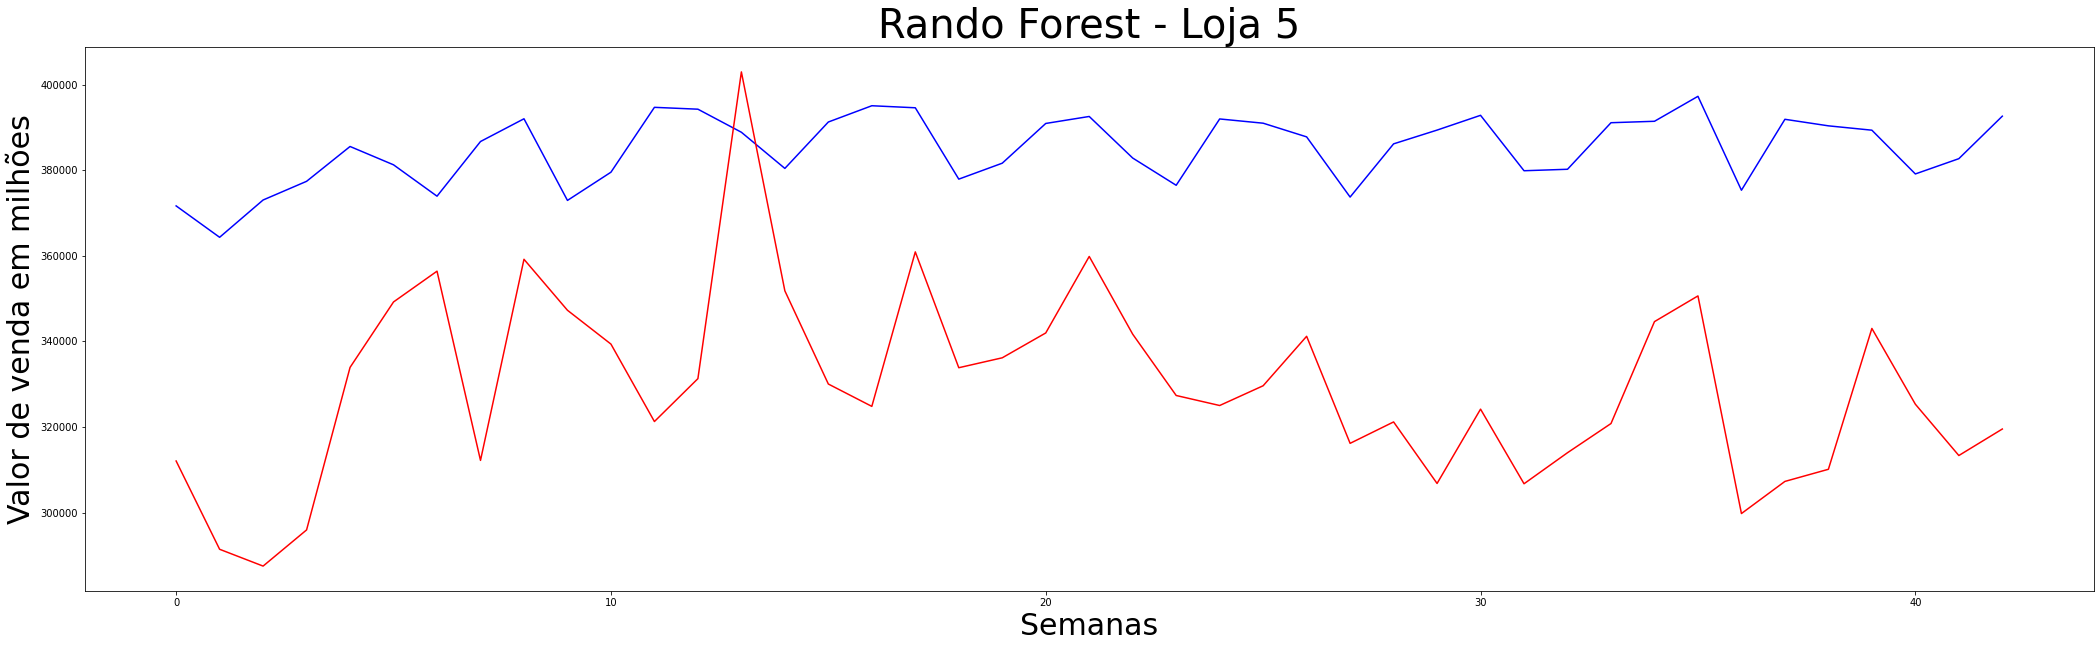

**************************************************
Resultados Loja 6:
383731.4121802326 399253.57890549995


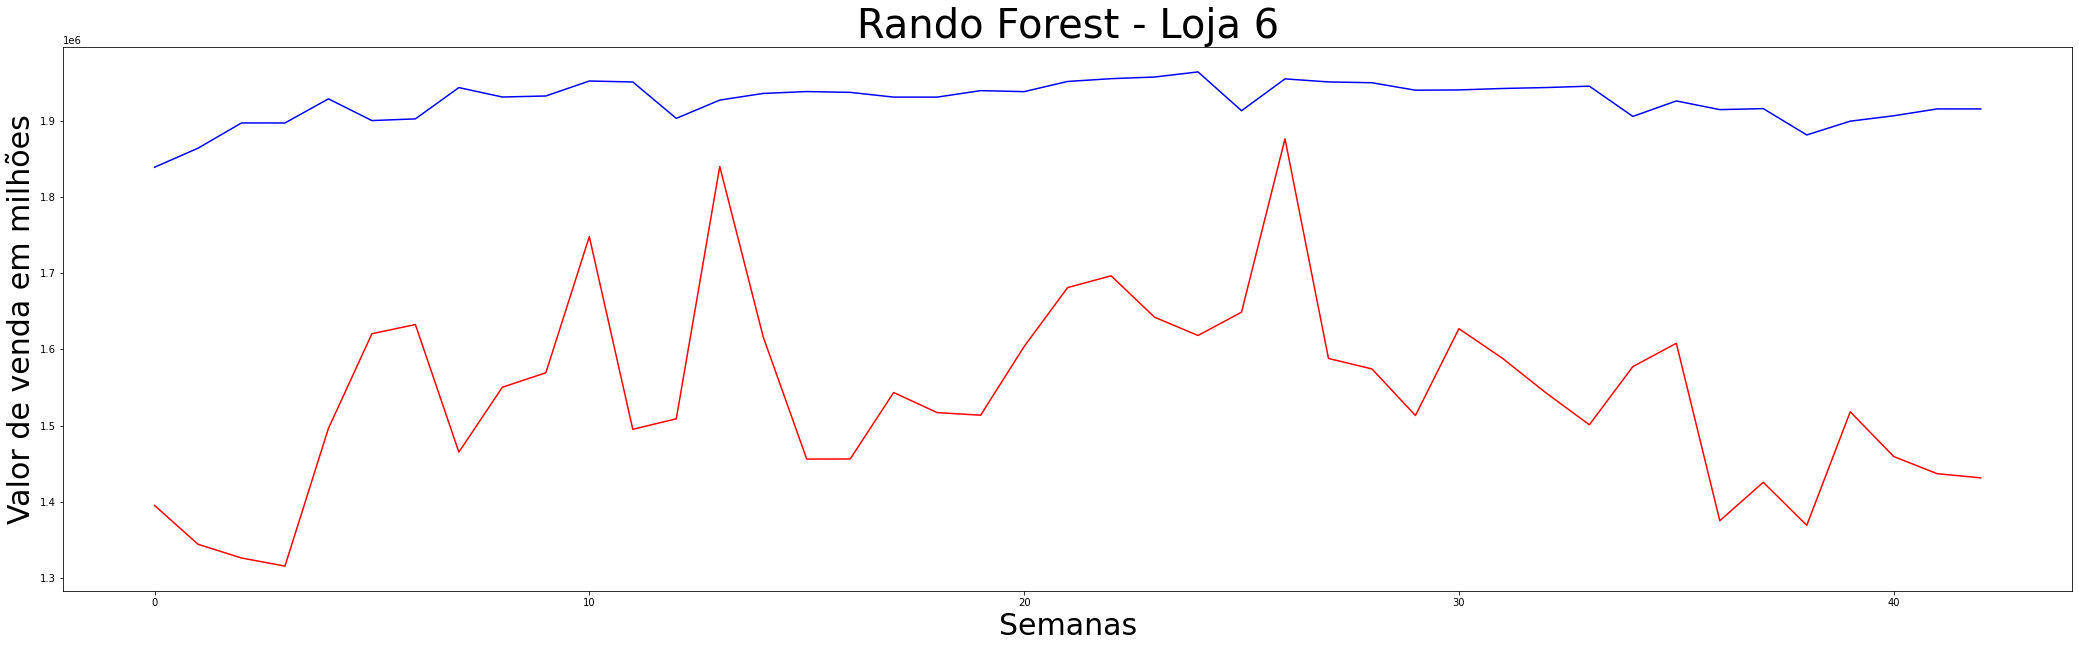

**************************************************
Resultados Loja 7:
147522.93893895348 161556.6368119142


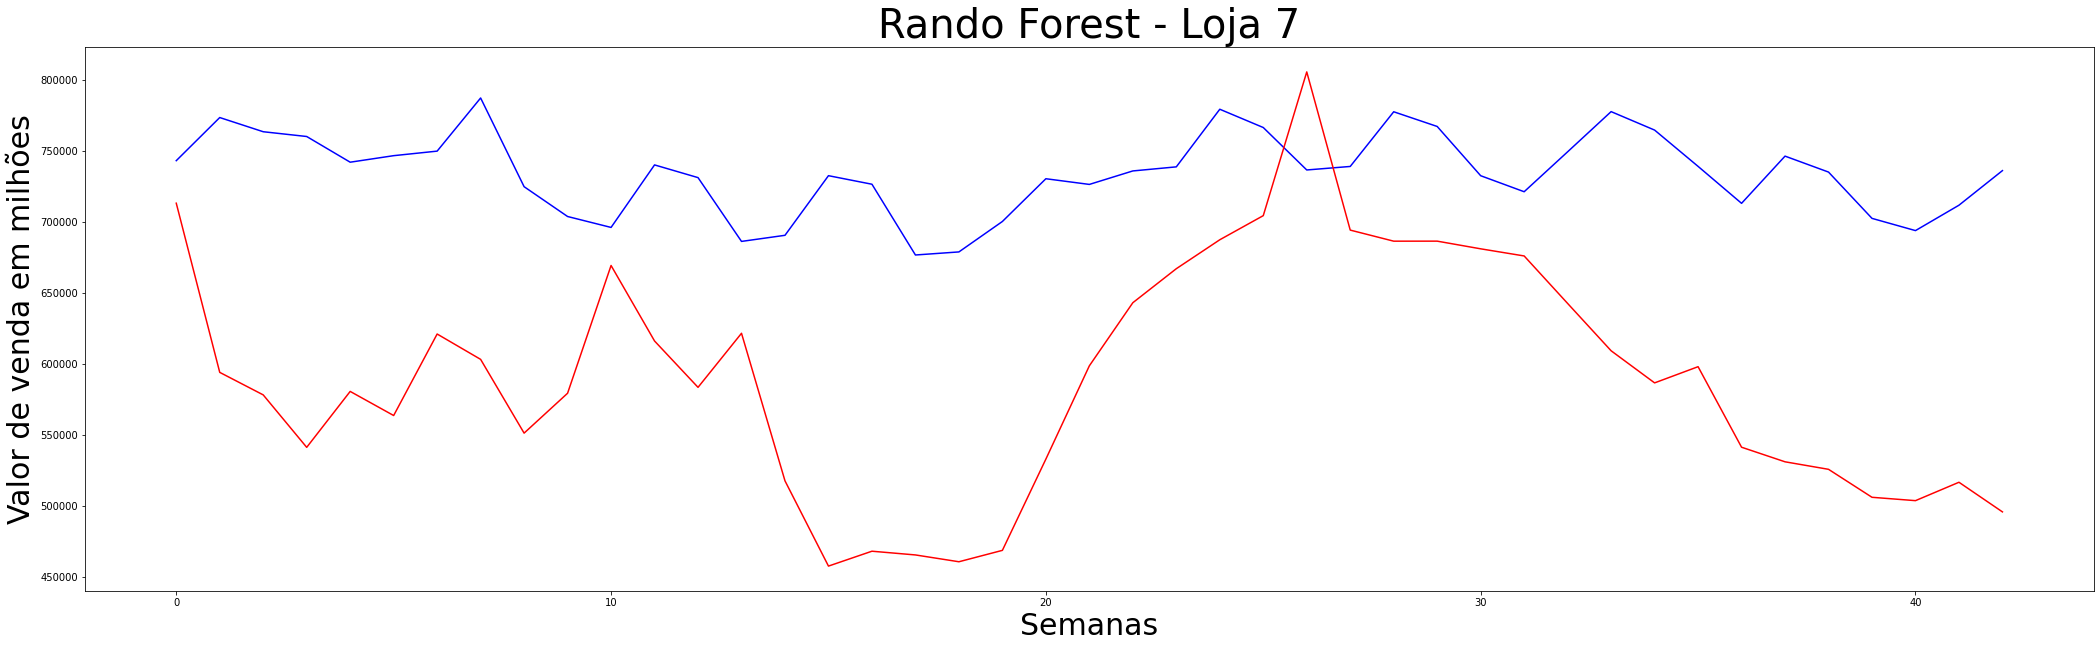

**************************************************
Resultados Loja 8:
130858.53590116277 138481.48956354655


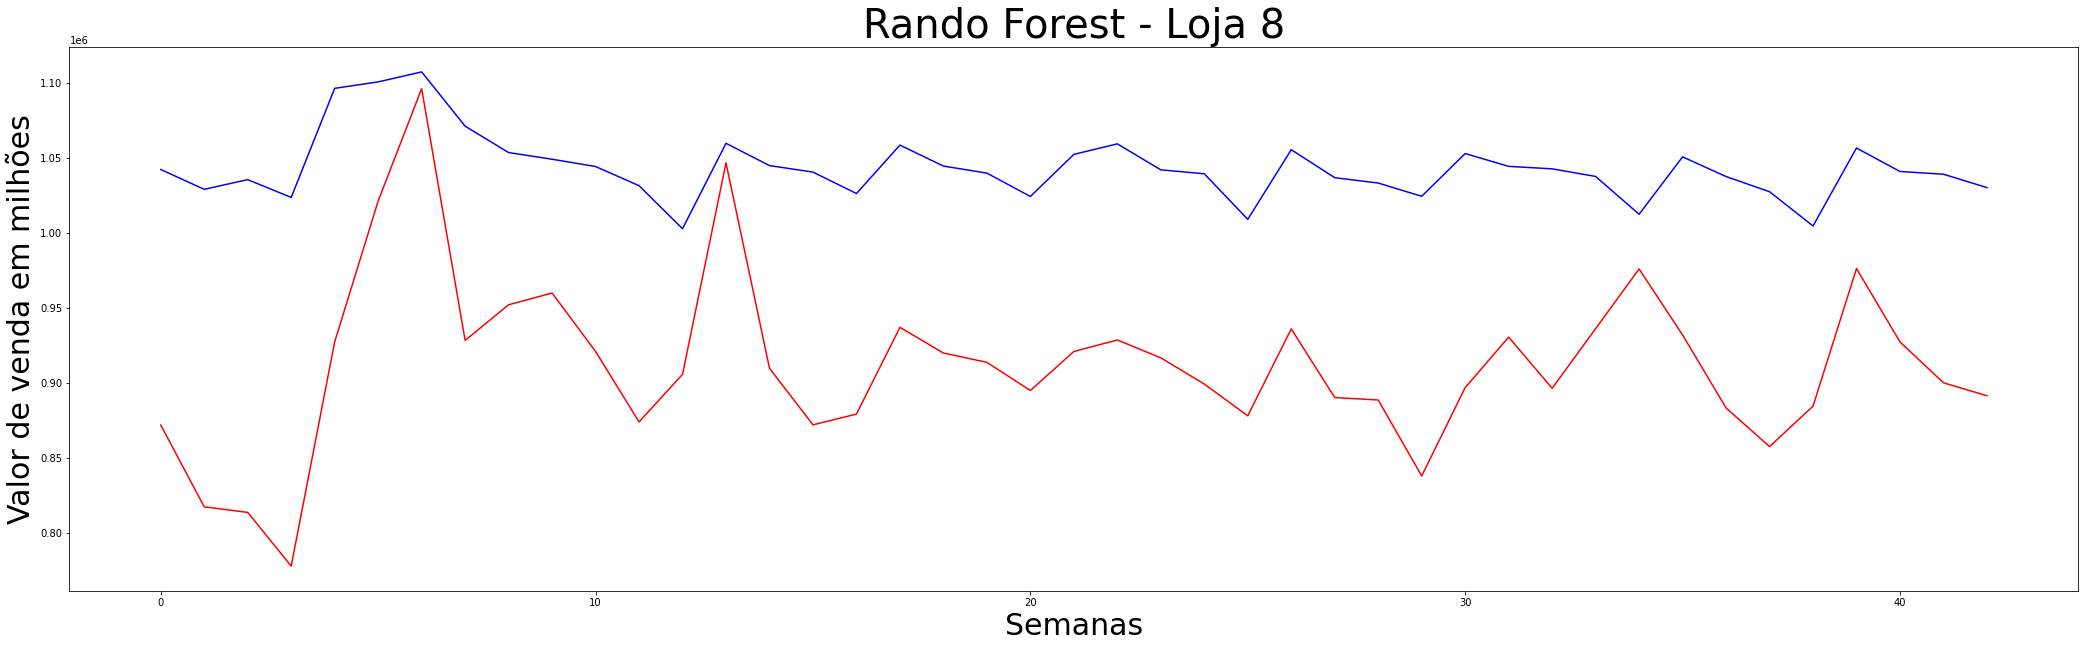

**************************************************
Resultados Loja 9:
119213.67143168603 126912.8160563609


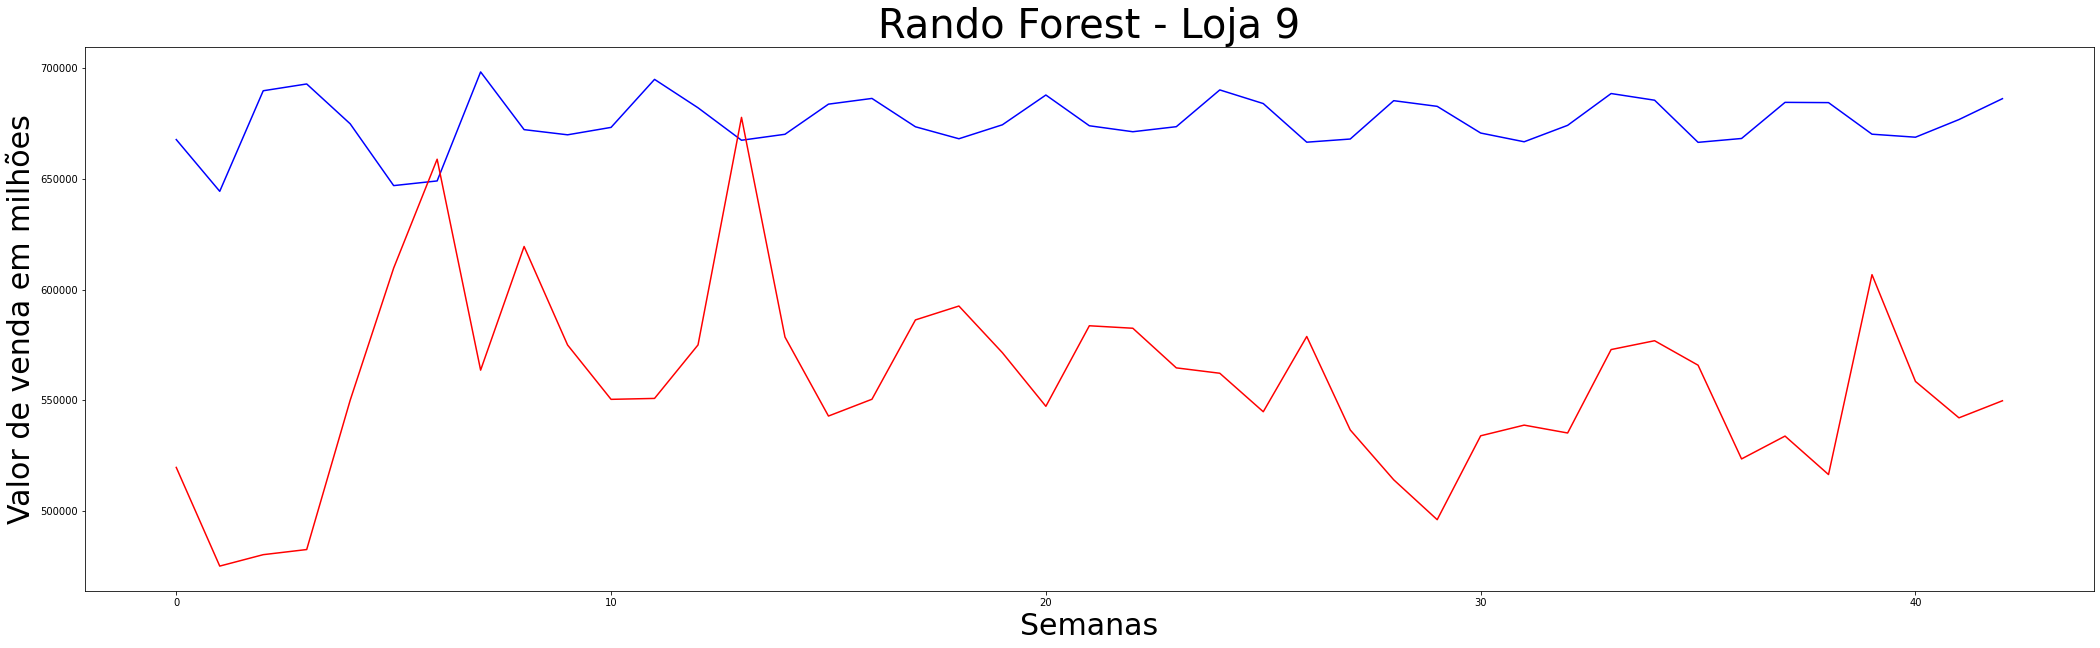

**************************************************
Resultados Loja 10:
502082.8081104651 518818.48876086465


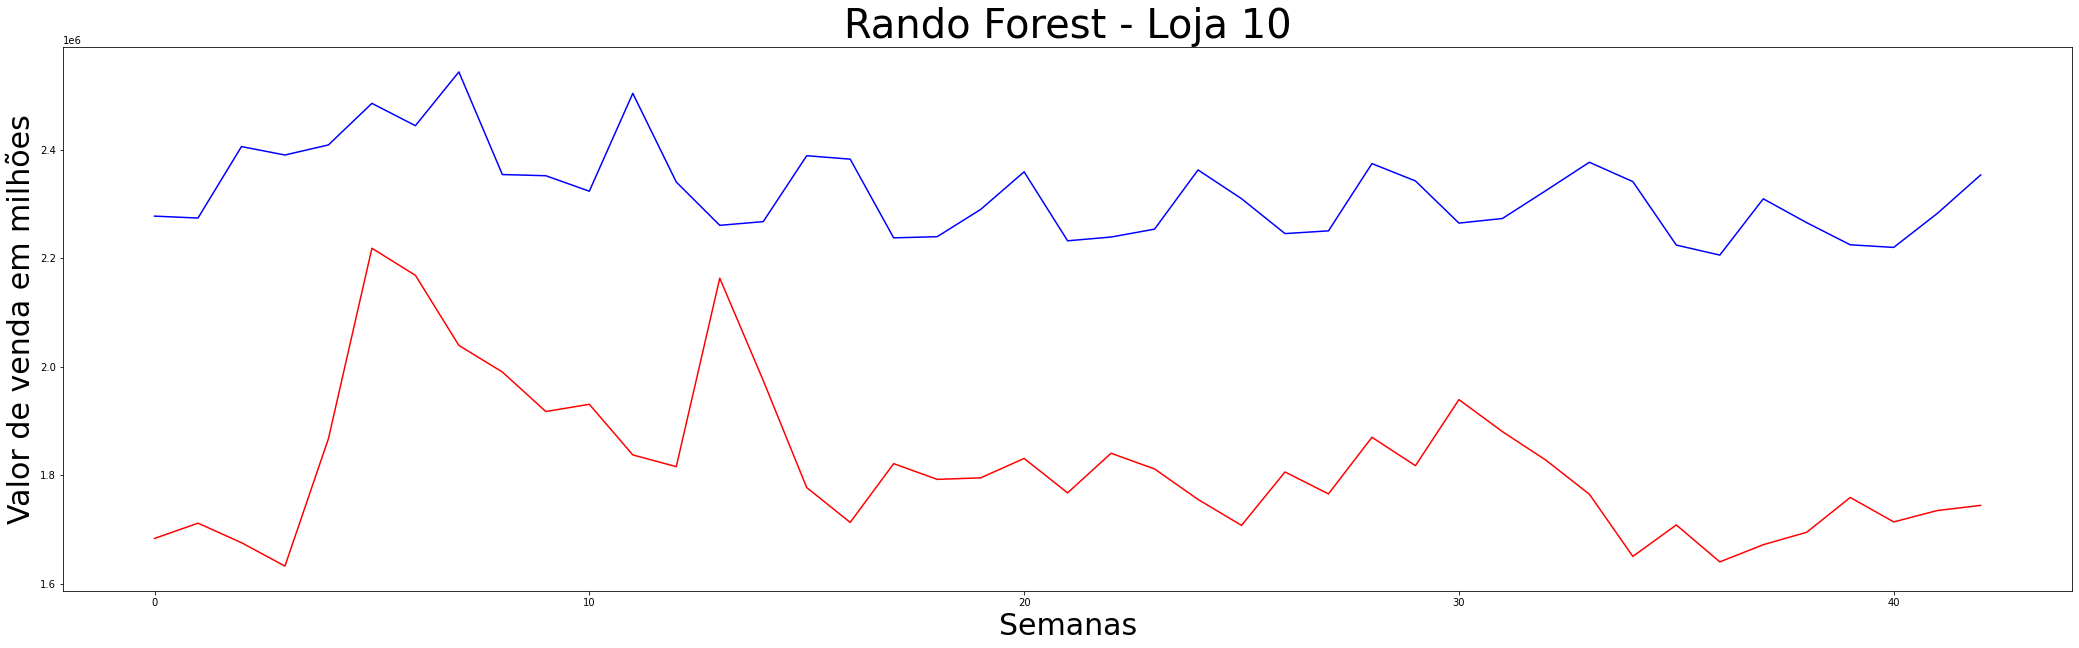

**************************************************
Resultados Loja 11:
205441.38613372092 219104.2616360238


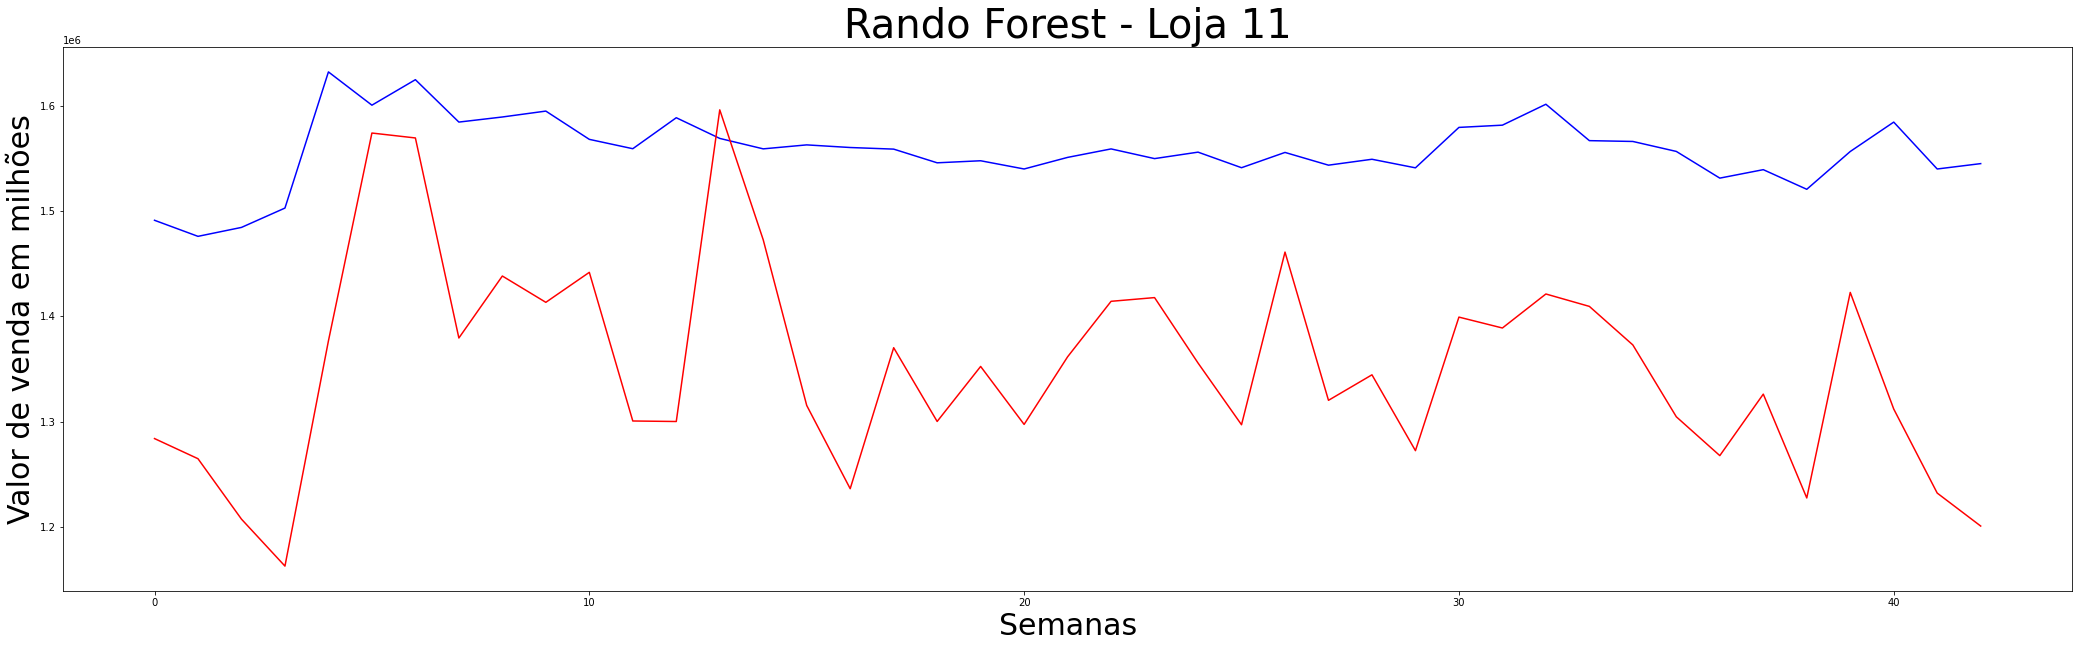

**************************************************
Resultados Loja 12:
46227.88381540698 58711.65606361077


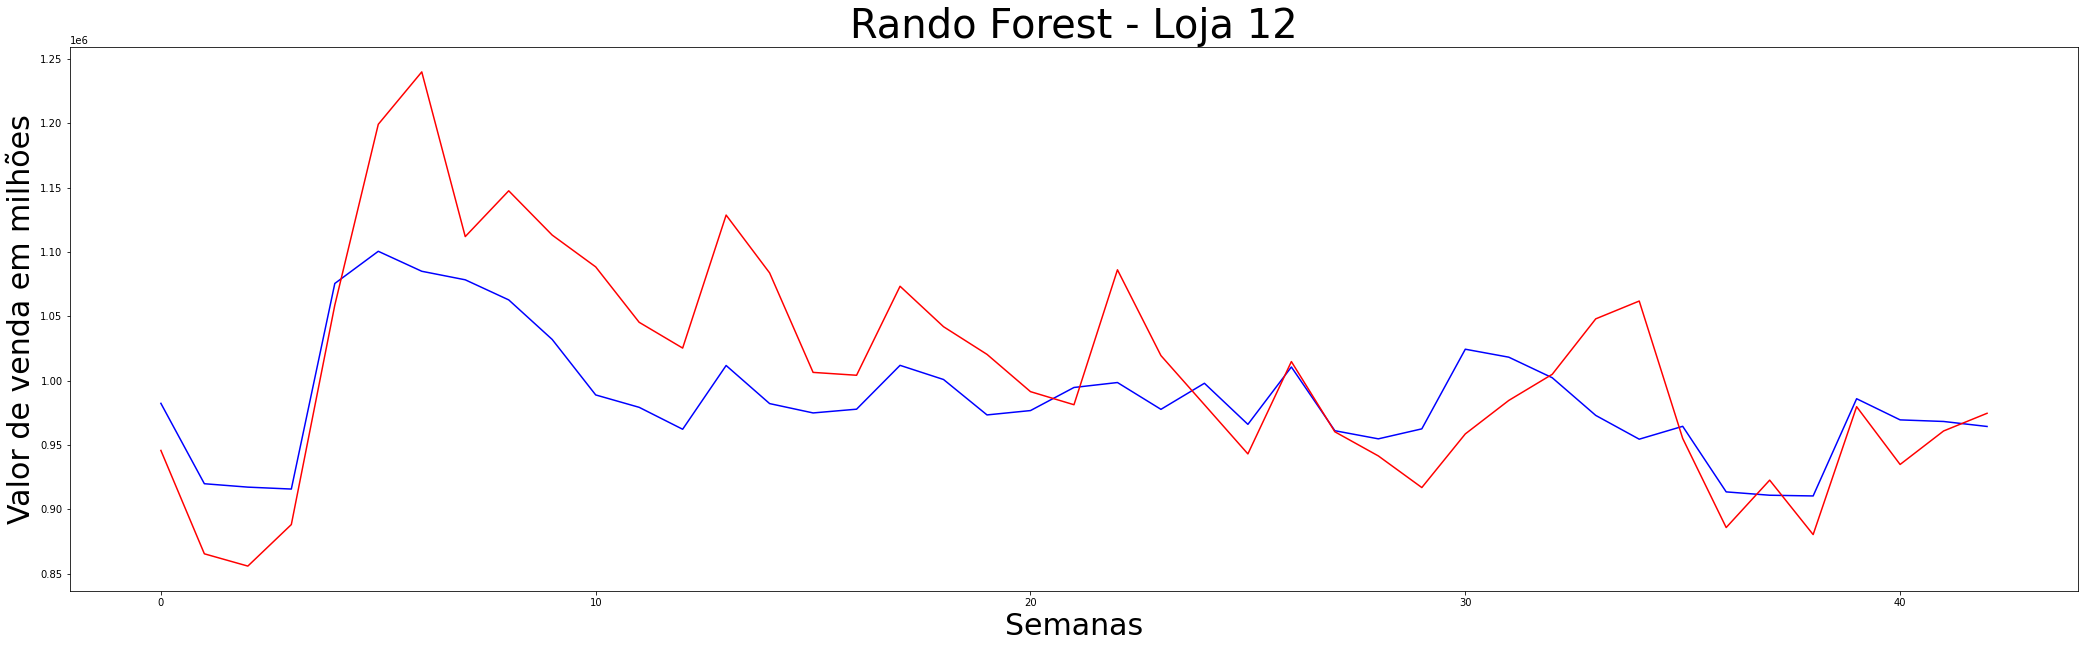

**************************************************
Resultados Loja 13:
502425.9850000001 517706.5304398194


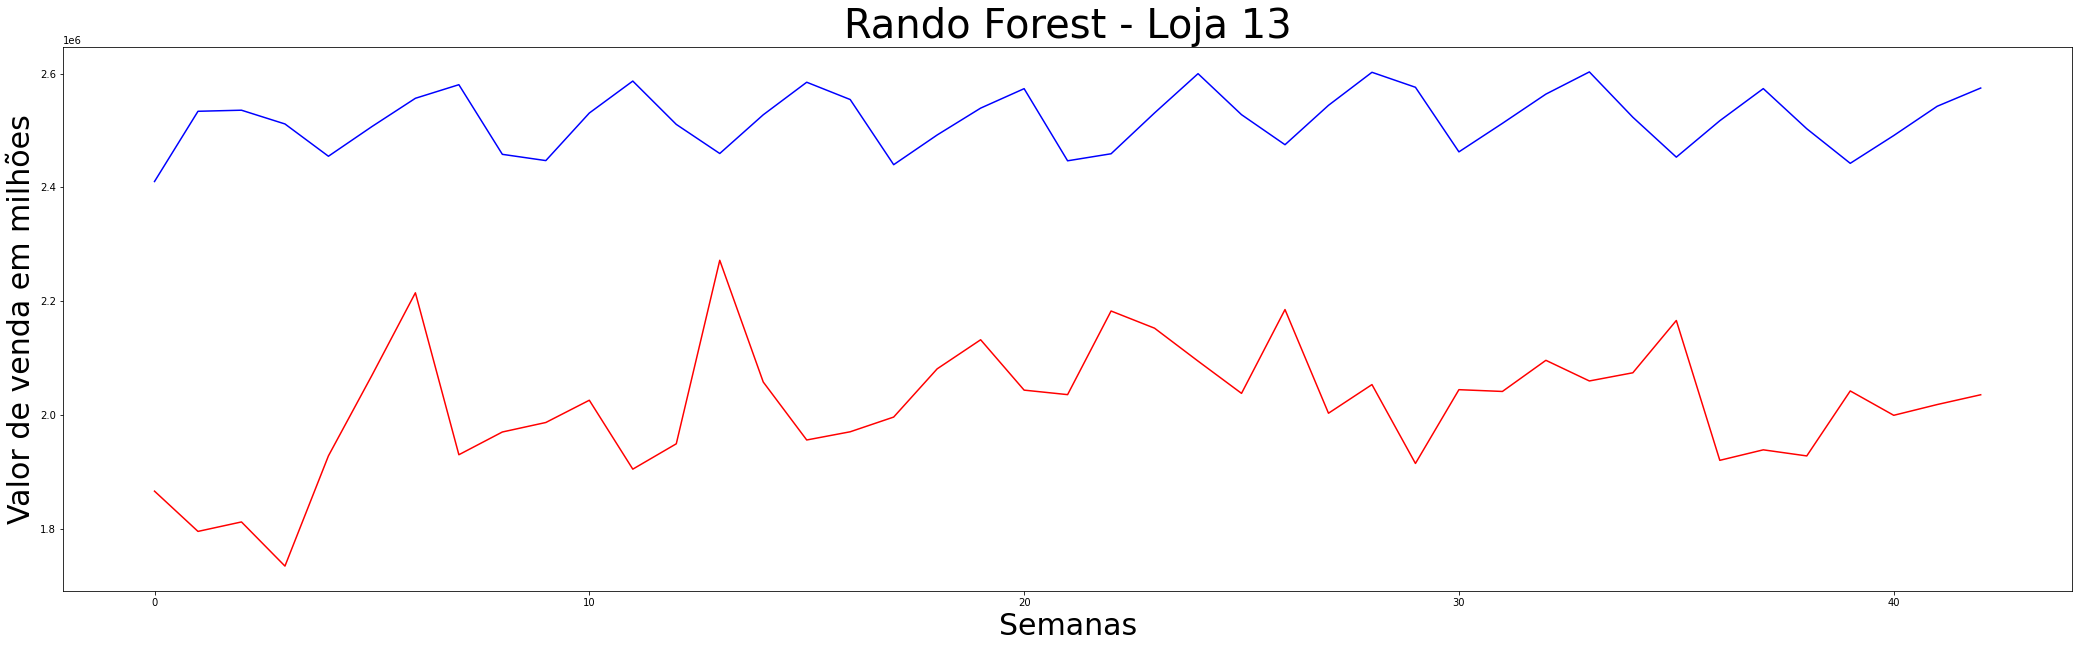

**************************************************
Resultados Loja 14:
525780.9897093023 557971.8688947217


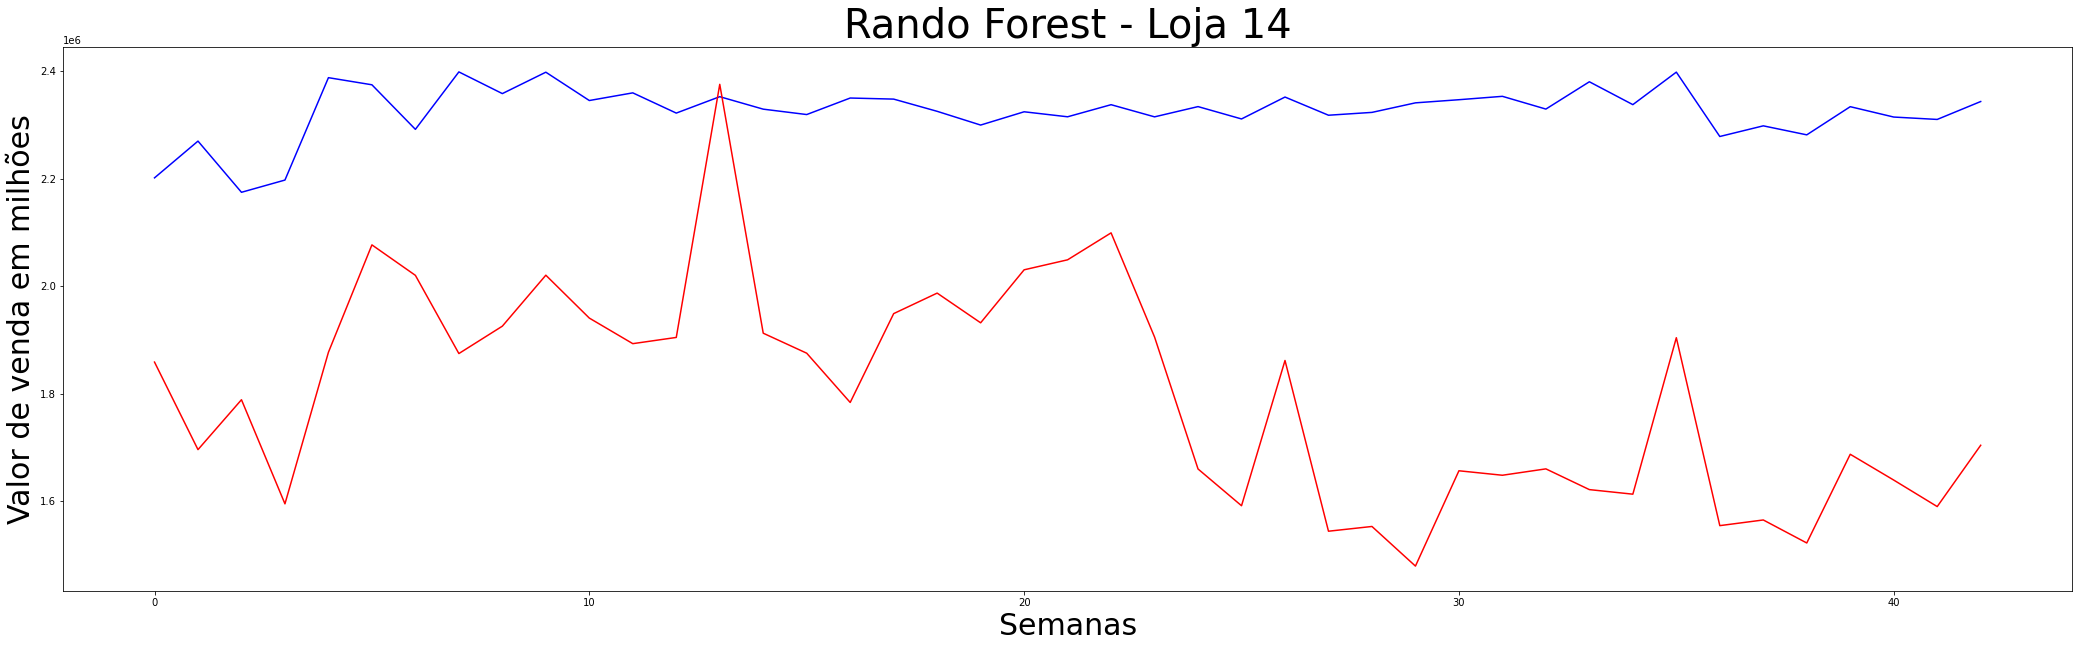

**************************************************
Resultados Loja 15:
101330.02279796512 109819.51785175876


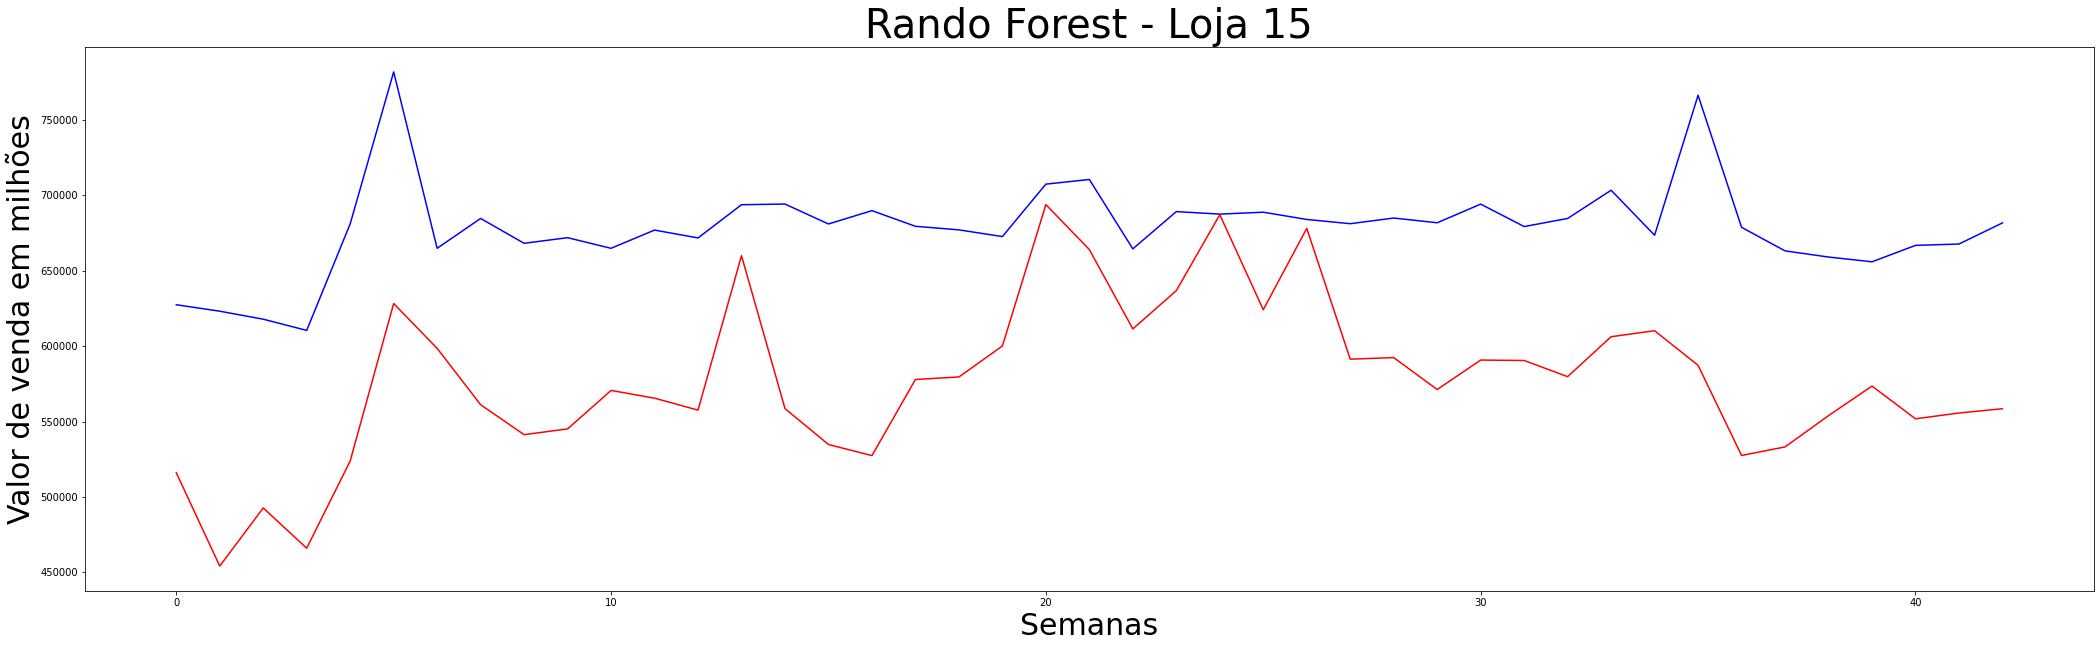

**************************************************
Resultados Loja 16:
139872.35670058138 149650.59932317722


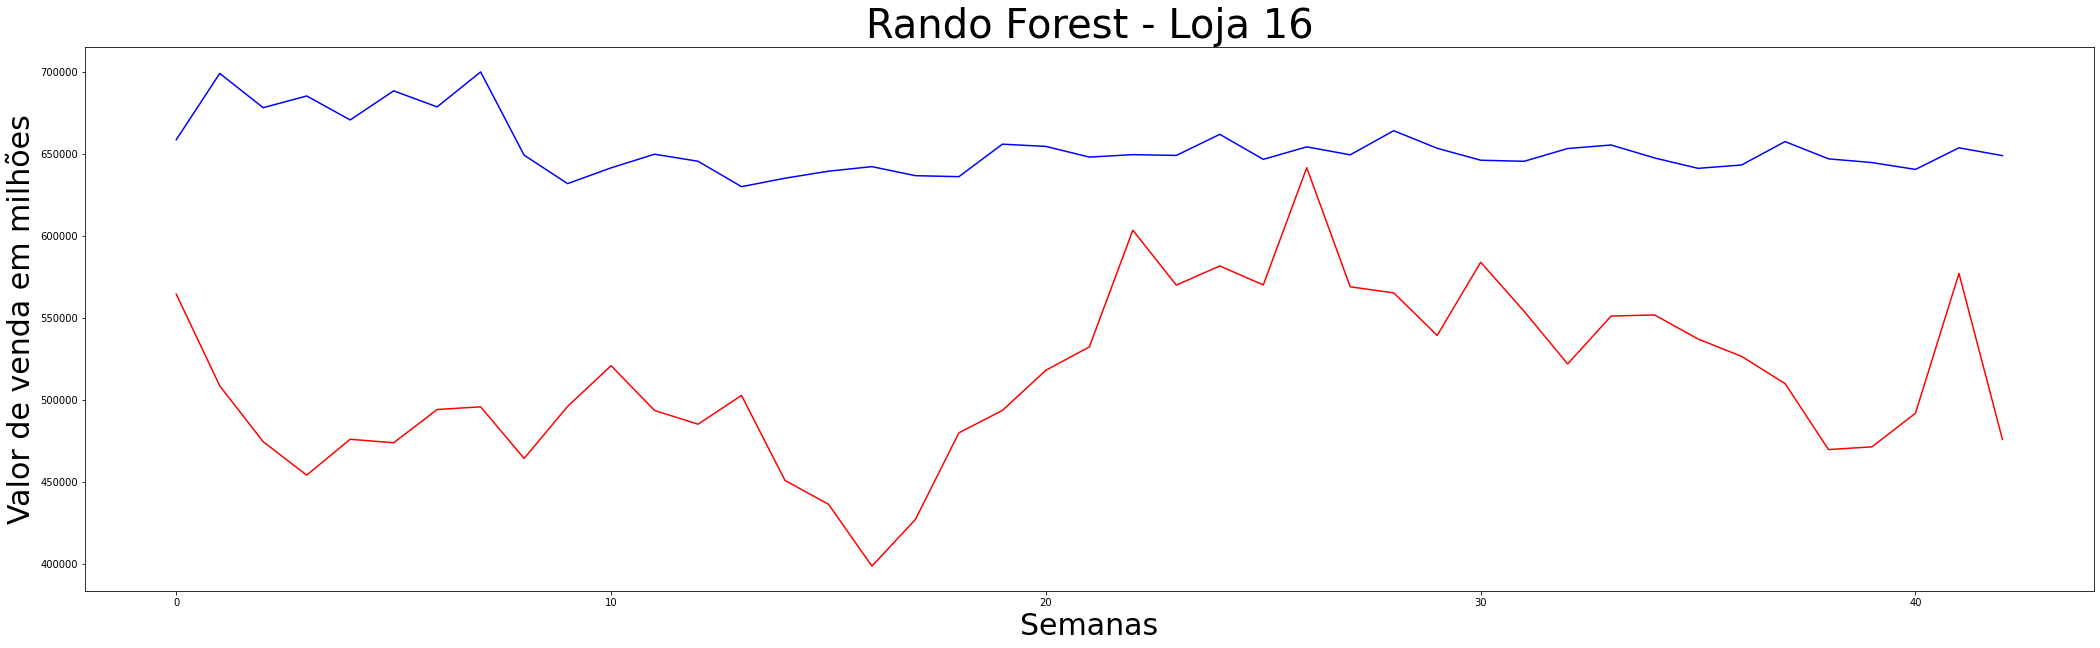

**************************************************
Resultados Loja 17:
55631.74816860465 80440.84072446608


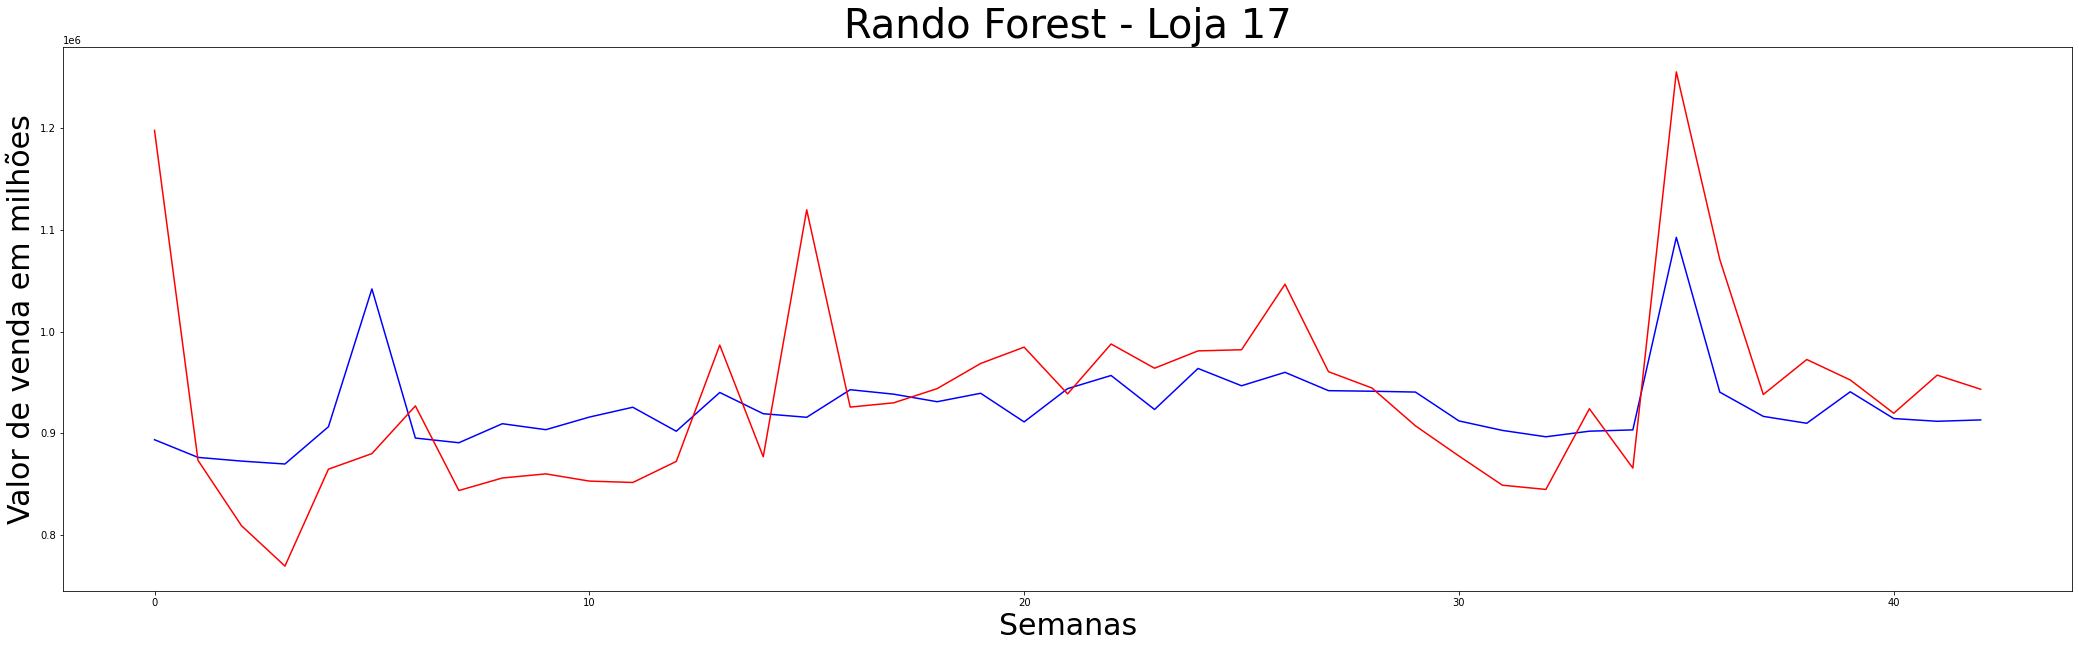

**************************************************
Resultados Loja 18:
83863.30433139532 94041.95705331714


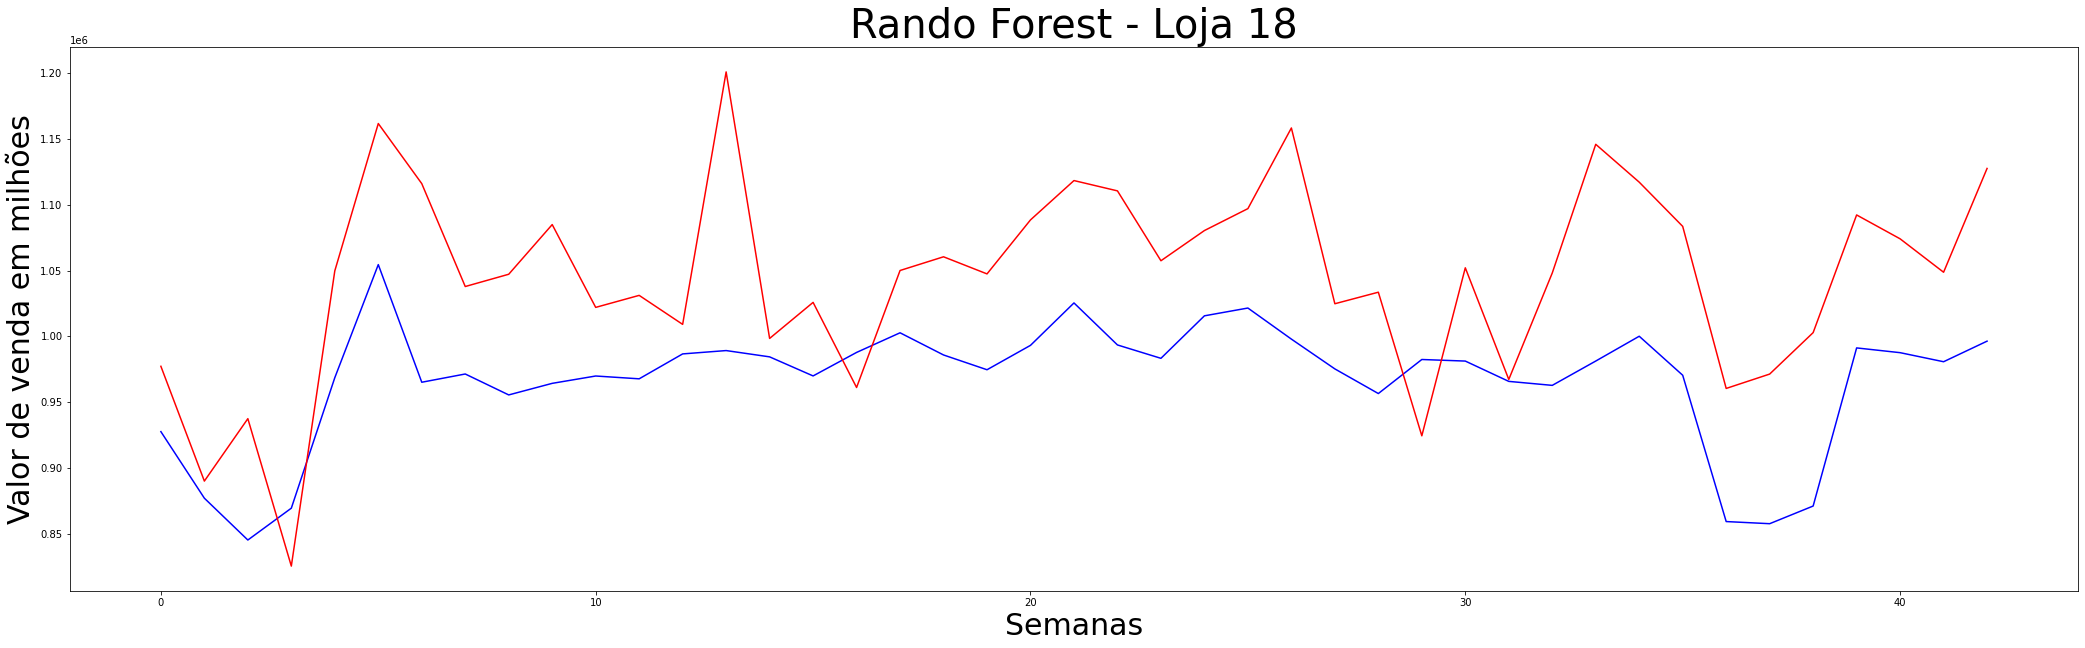

**************************************************
Resultados Loja 19:
144588.3979360465 161455.80310457537


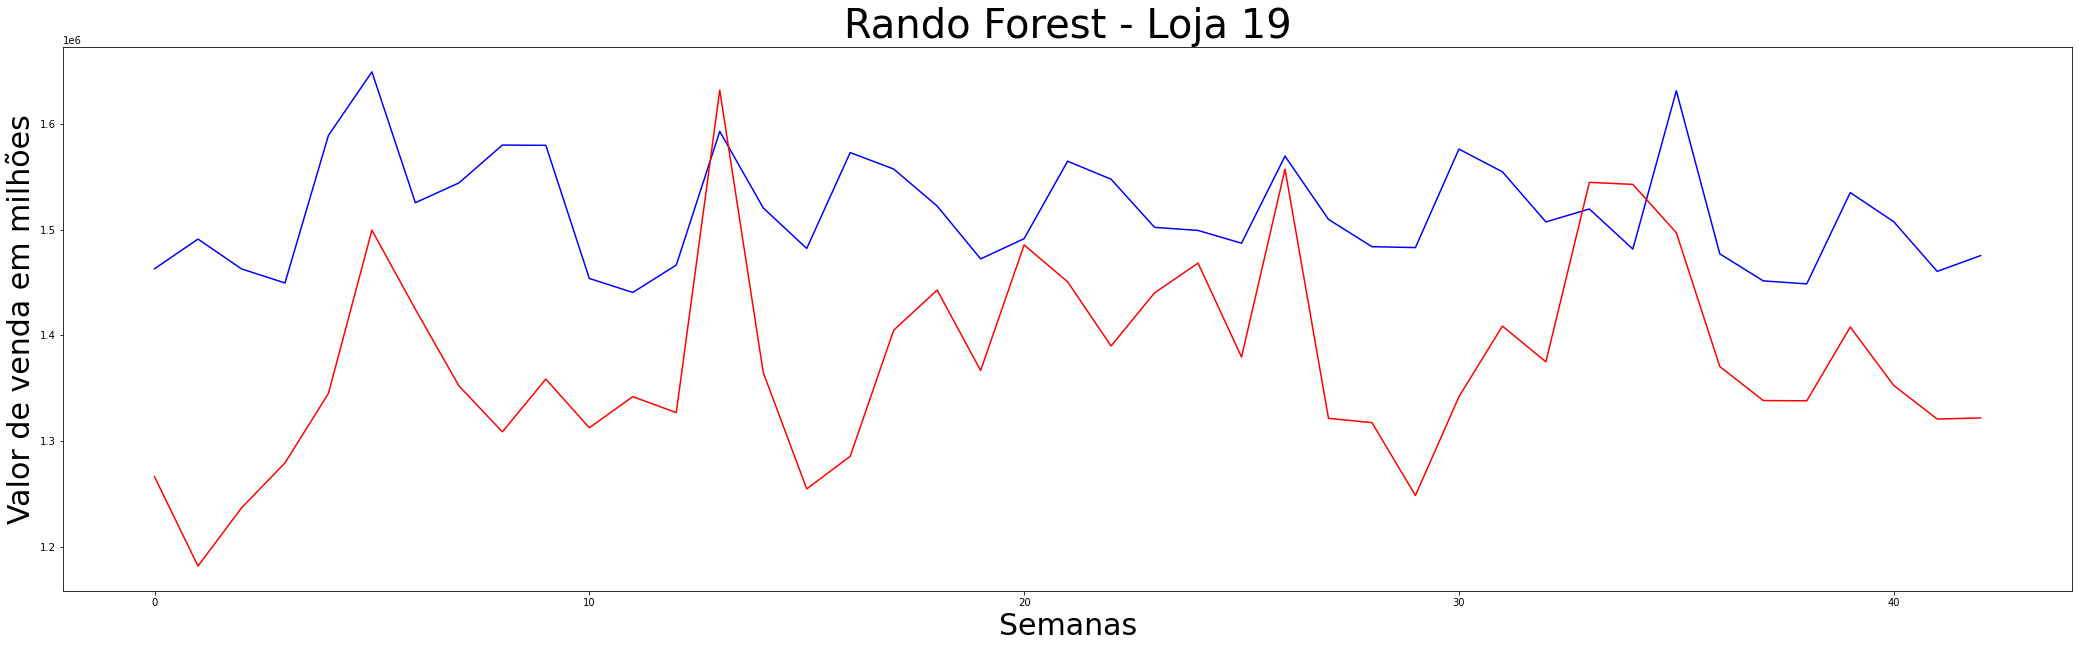

**************************************************
Resultados Loja 20:
336432.19540697674 355660.74220103613


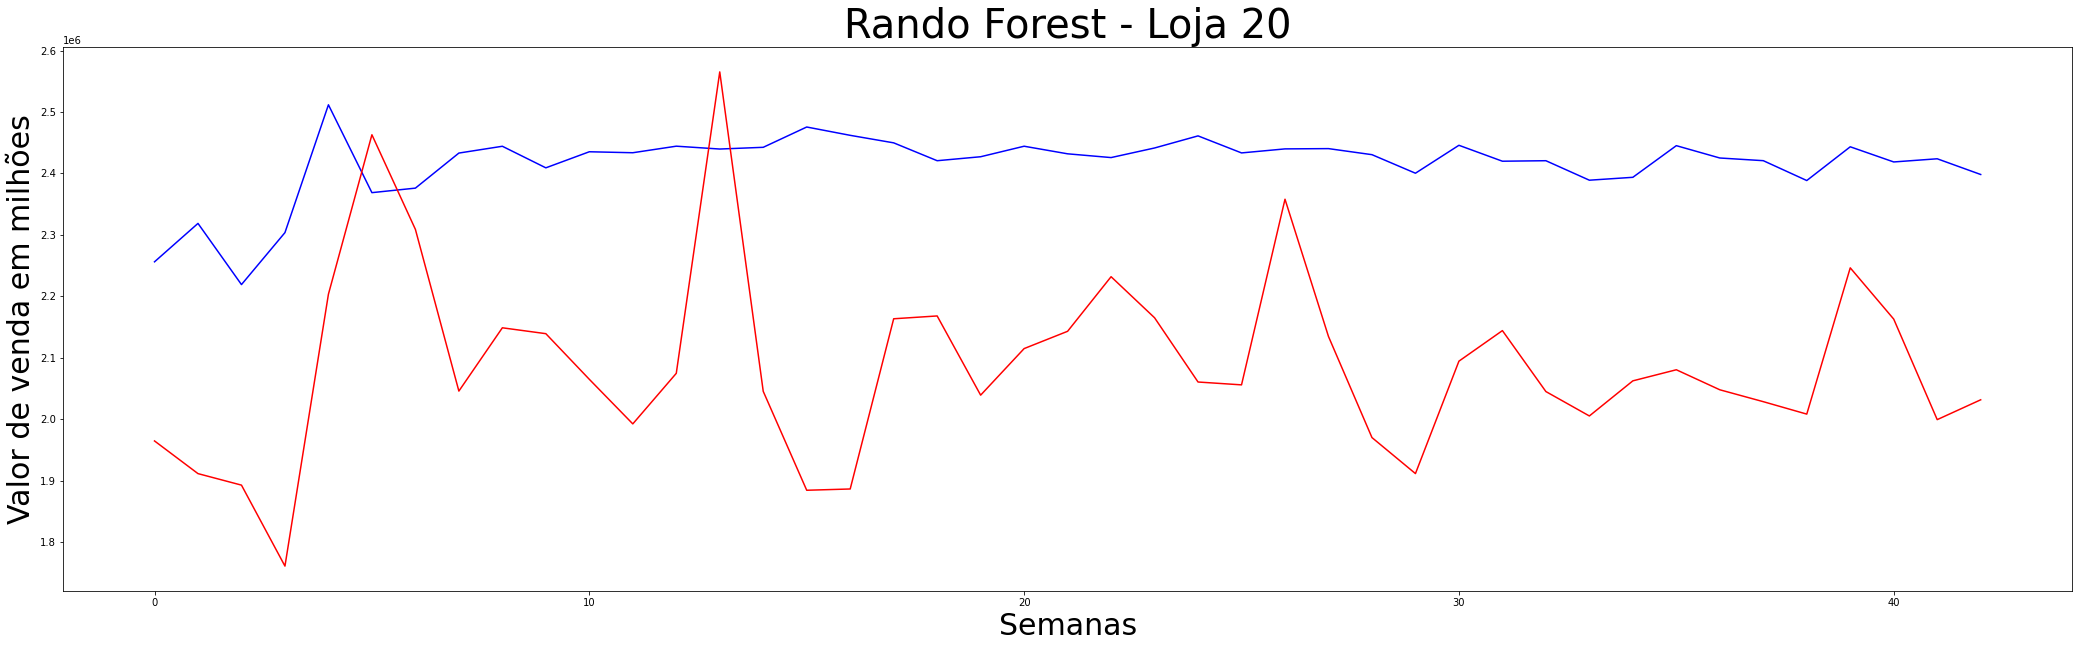

**************************************************
Resultados Loja 21:
274177.3021511628 277913.0302797039


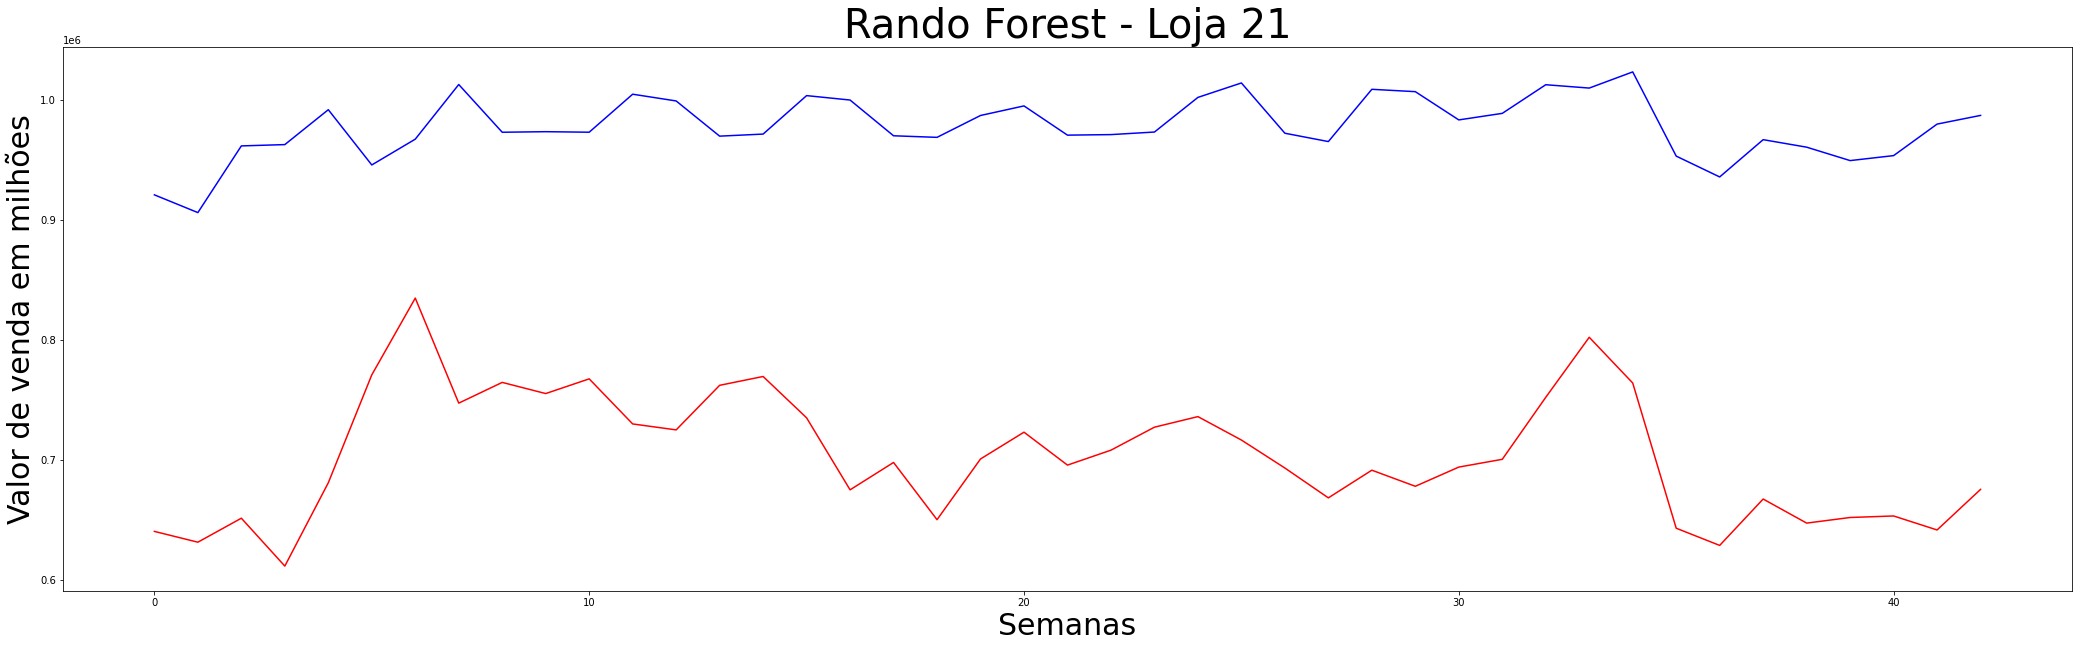

**************************************************
Resultados Loja 22:
45550.019941860475 61298.5963567349


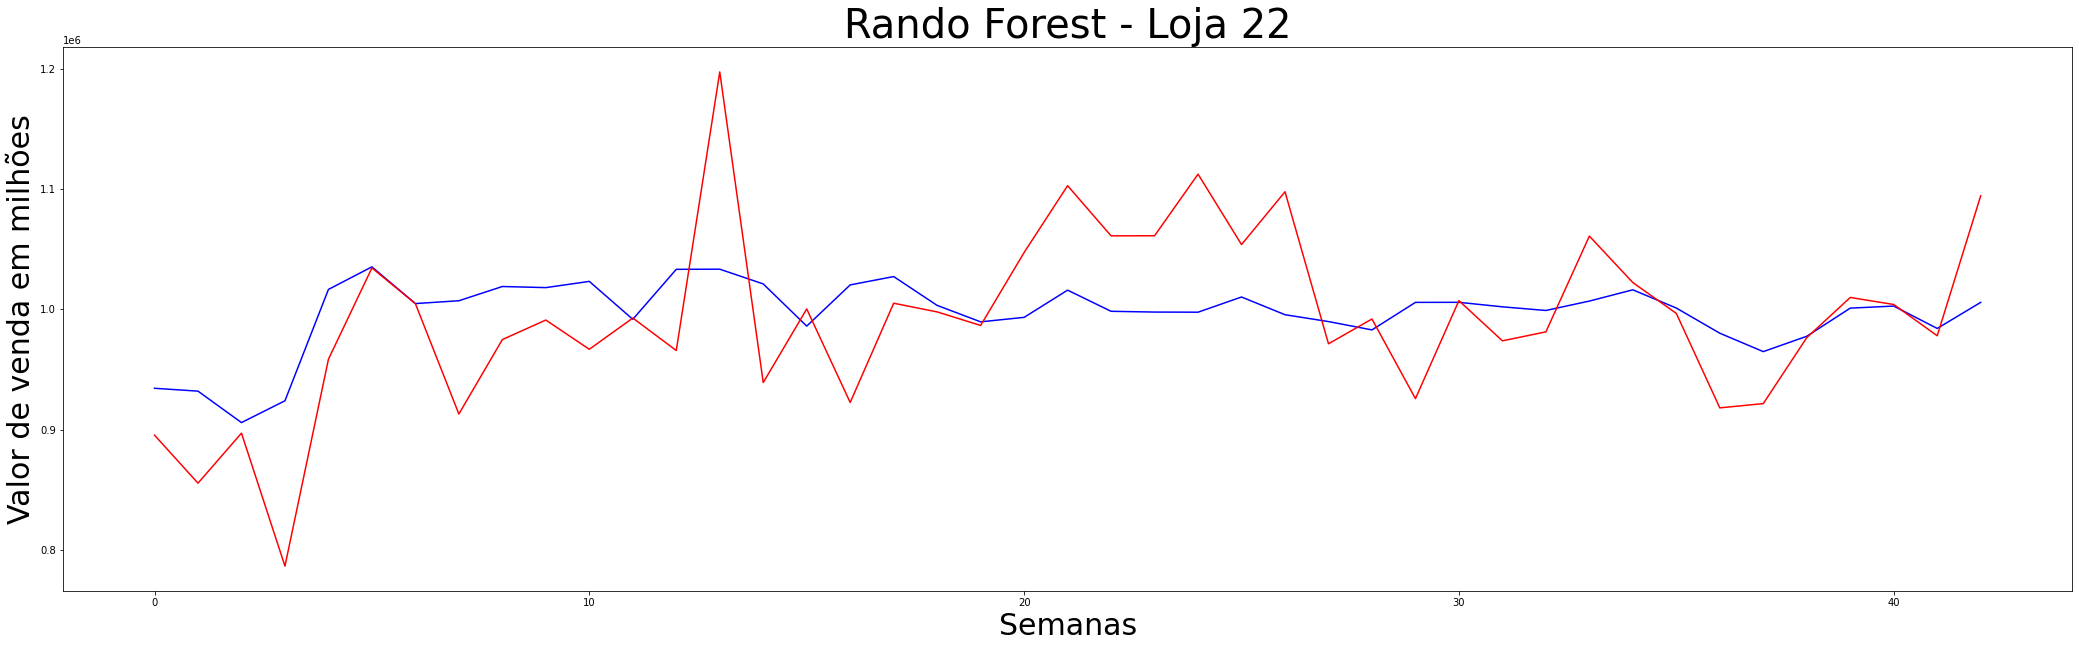

**************************************************
Resultados Loja 23:
170261.76236918606 205961.00622048348


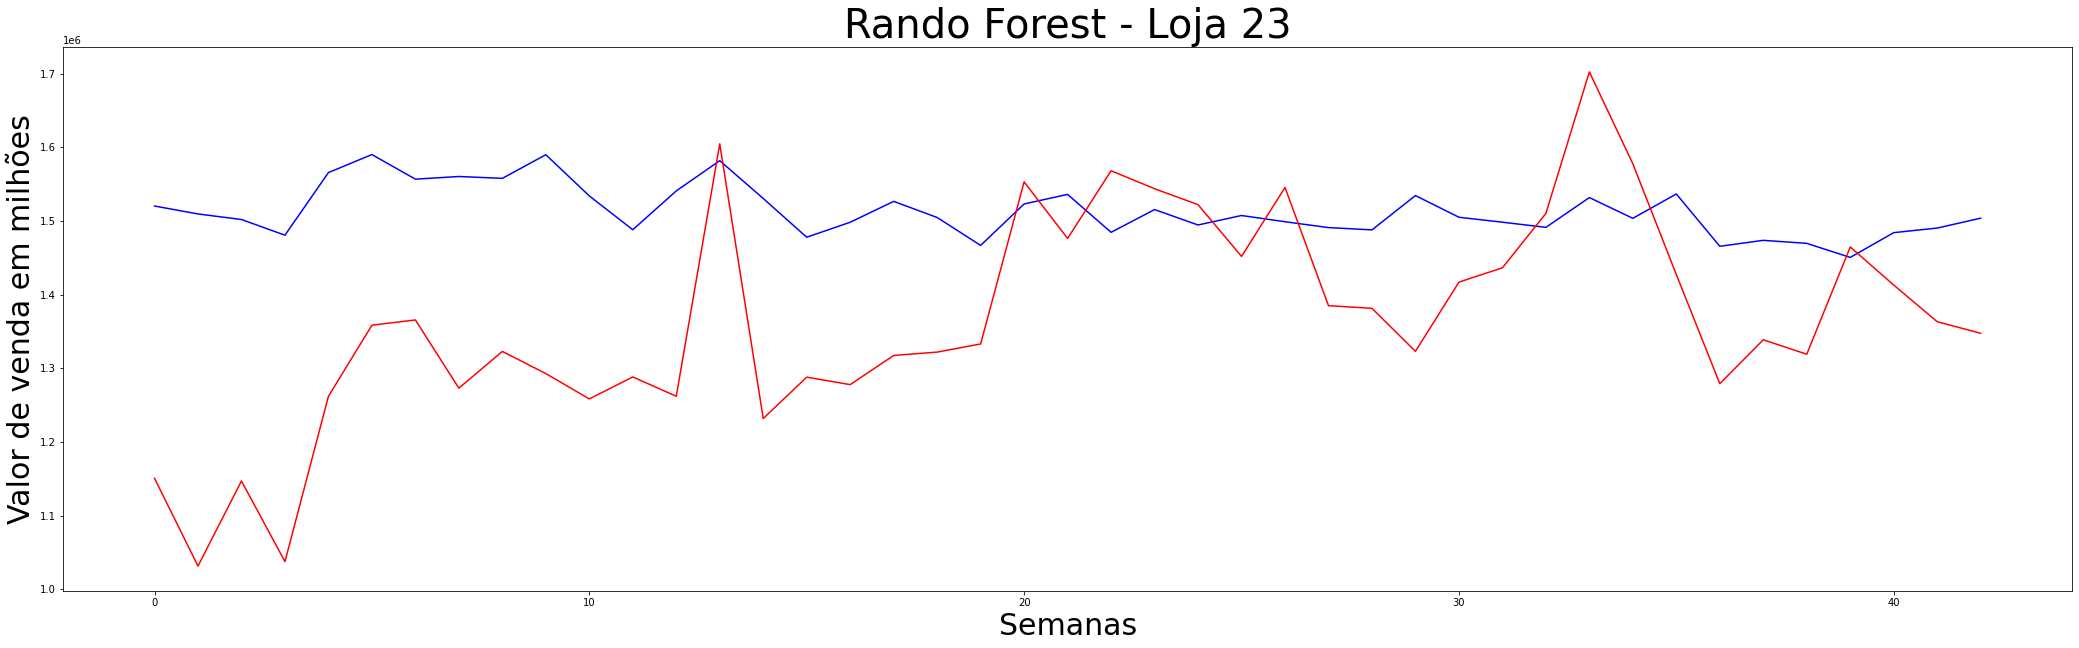

**************************************************
Resultados Loja 24:
153857.10273255815 166811.6615230754


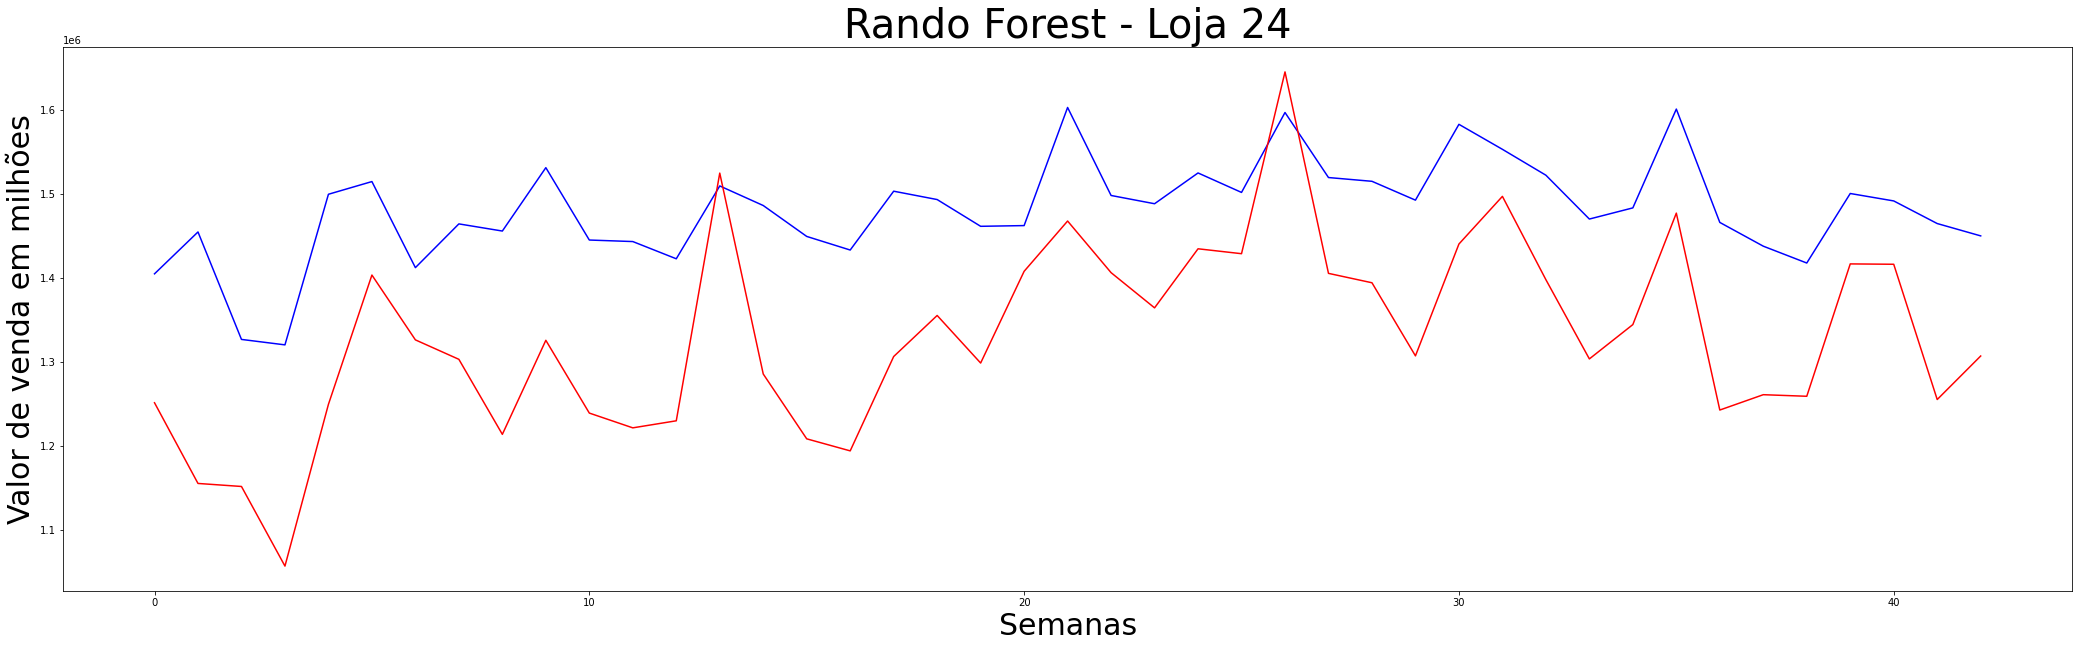

**************************************************
Resultados Loja 25:
123897.62437499998 149707.9838090261


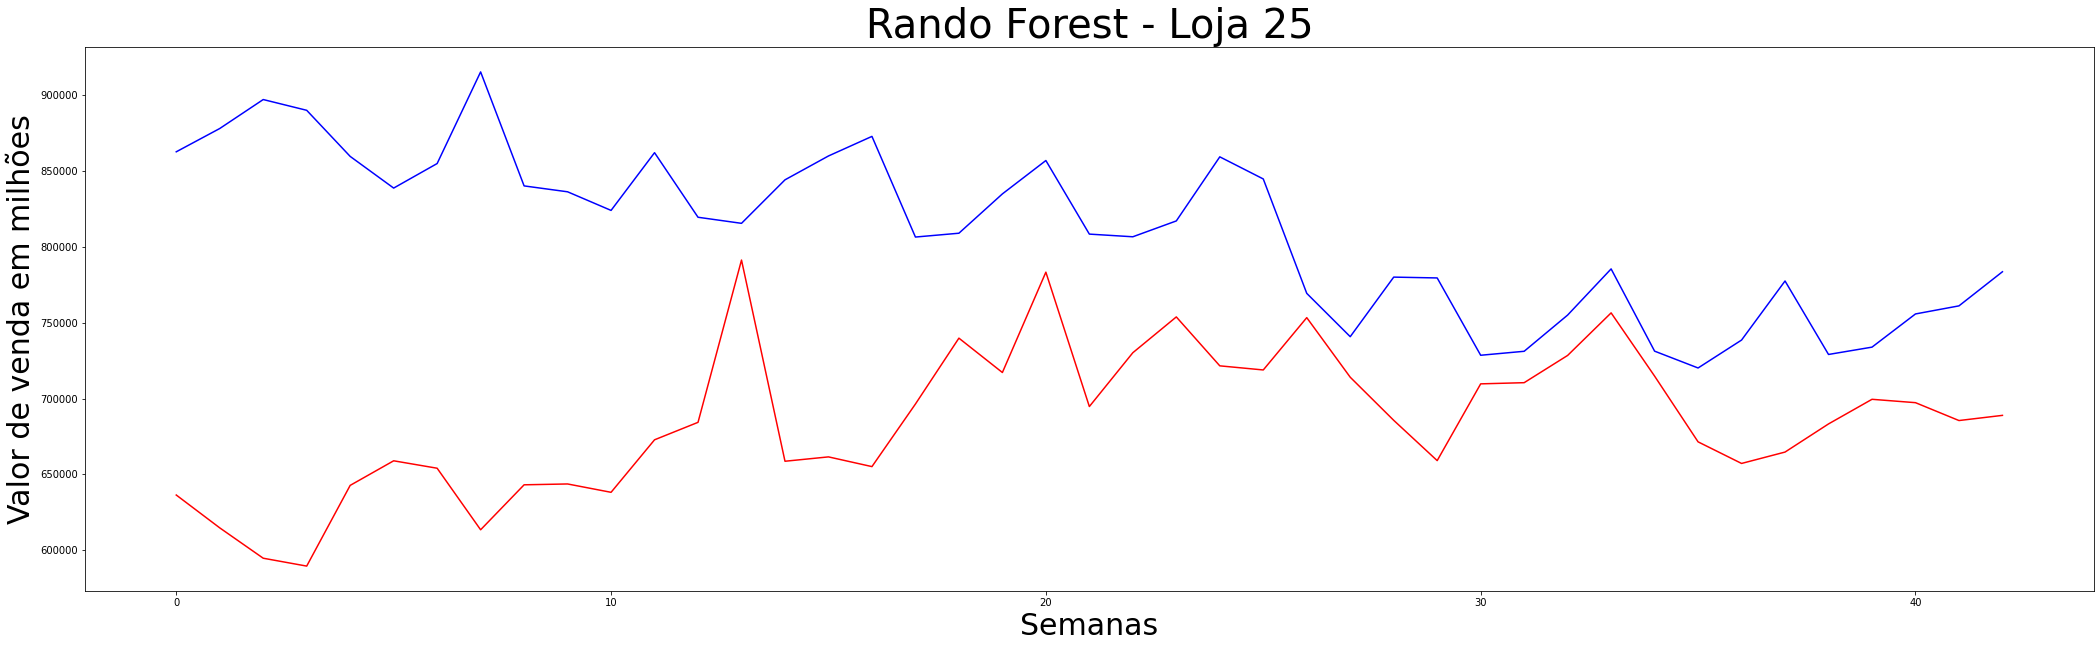

**************************************************
Resultados Loja 26:
87382.43210755812 102889.613239537


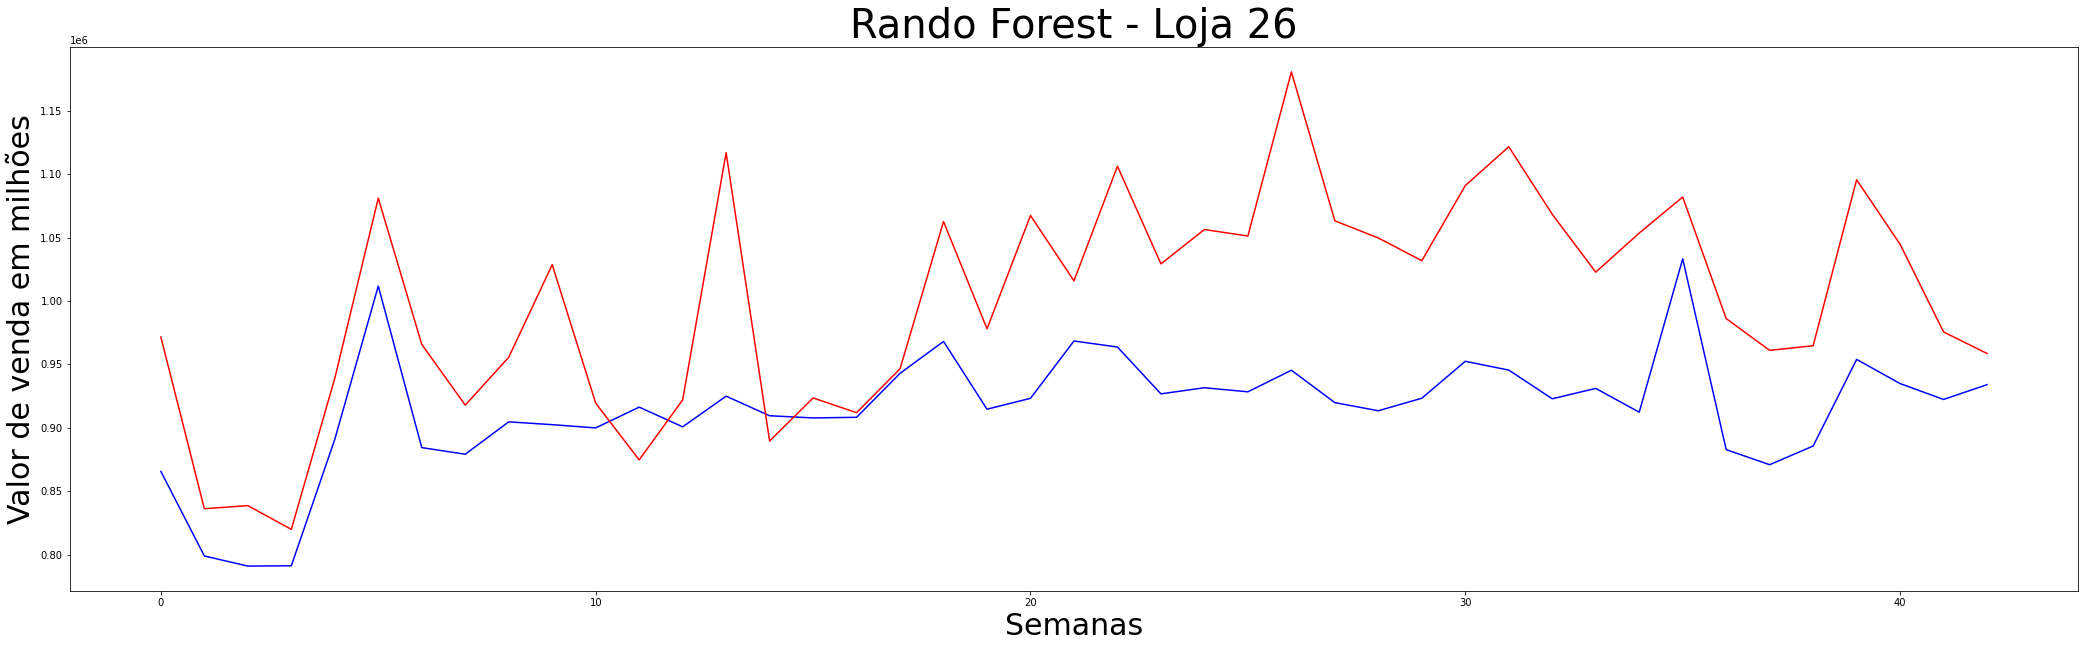

**************************************************
Resultados Loja 27:
177521.32624999998 196333.09298147153


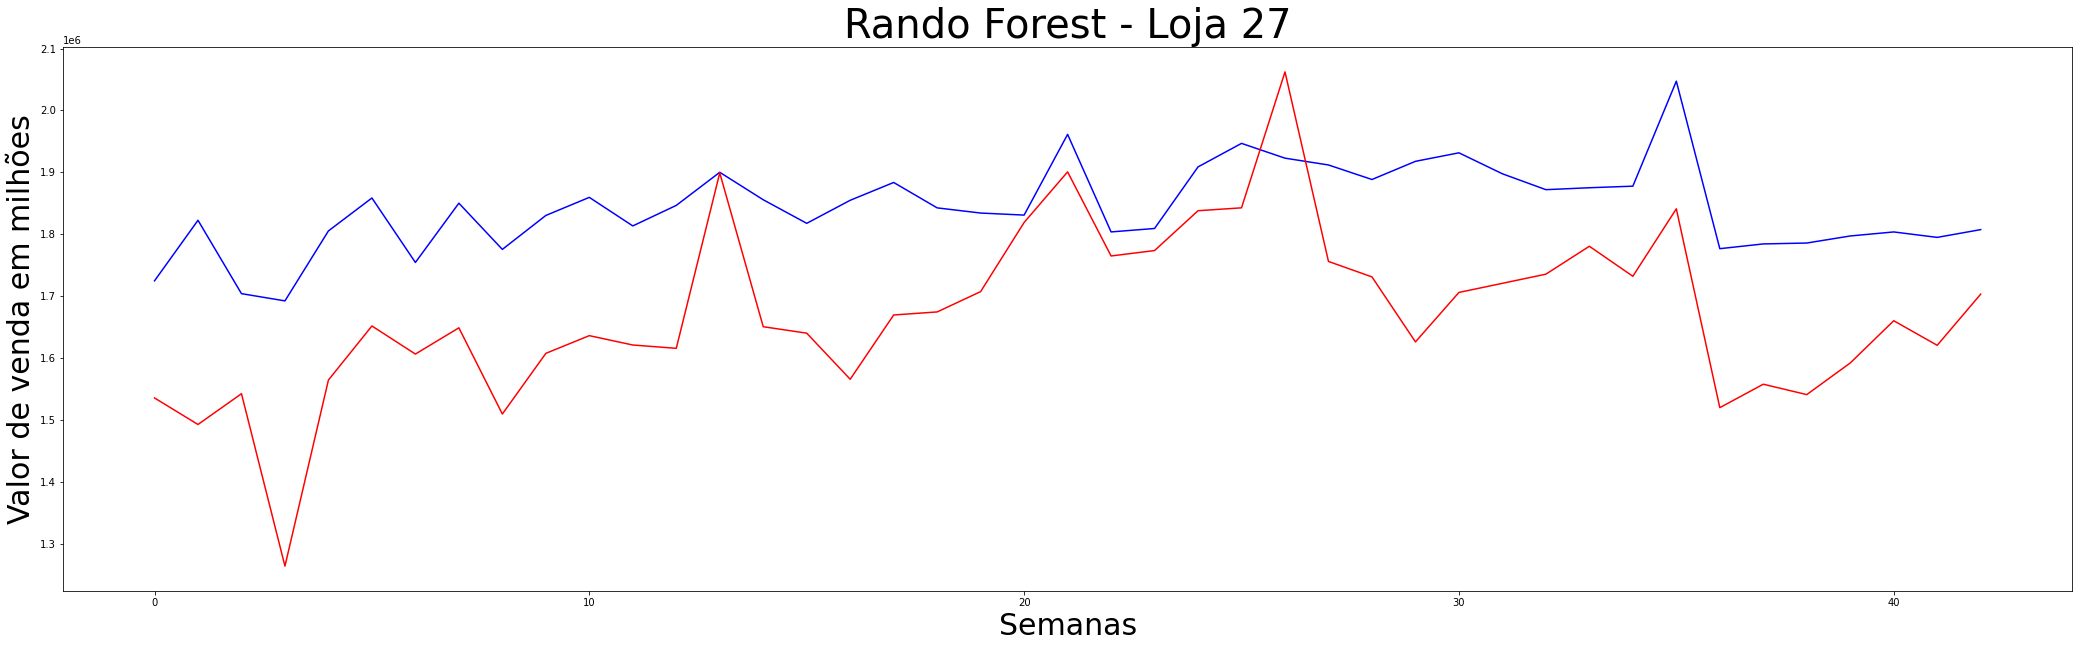

**************************************************
Resultados Loja 28:
101418.75505087209 127820.2728417564


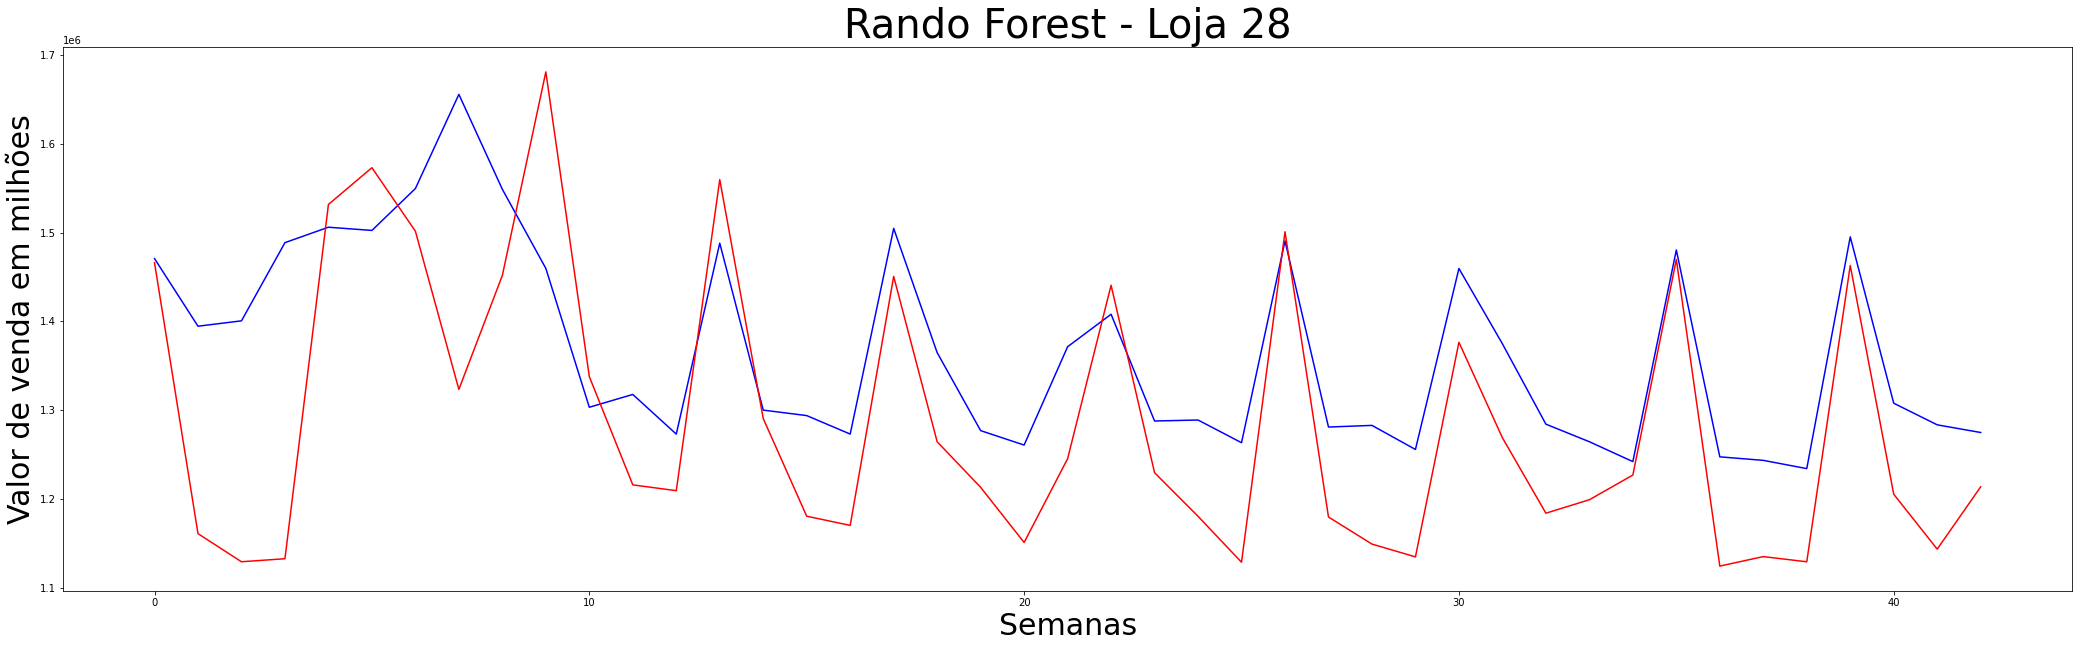

**************************************************
Resultados Loja 29:
74249.4969985465 80928.81223580145


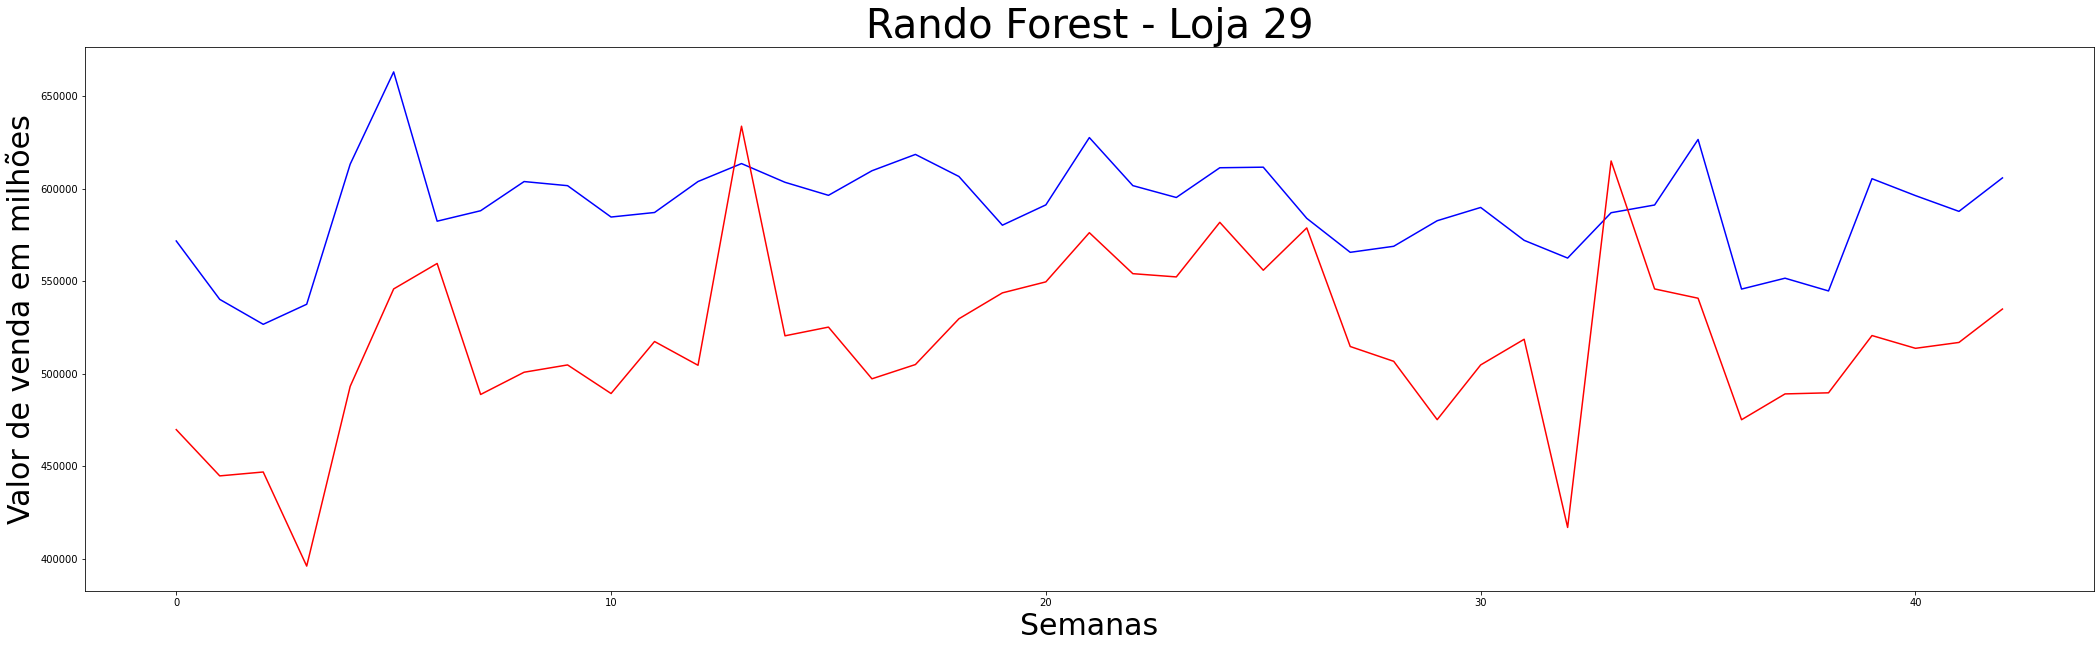

**************************************************
Resultados Loja 30:
68111.51882994185 79881.25968920926


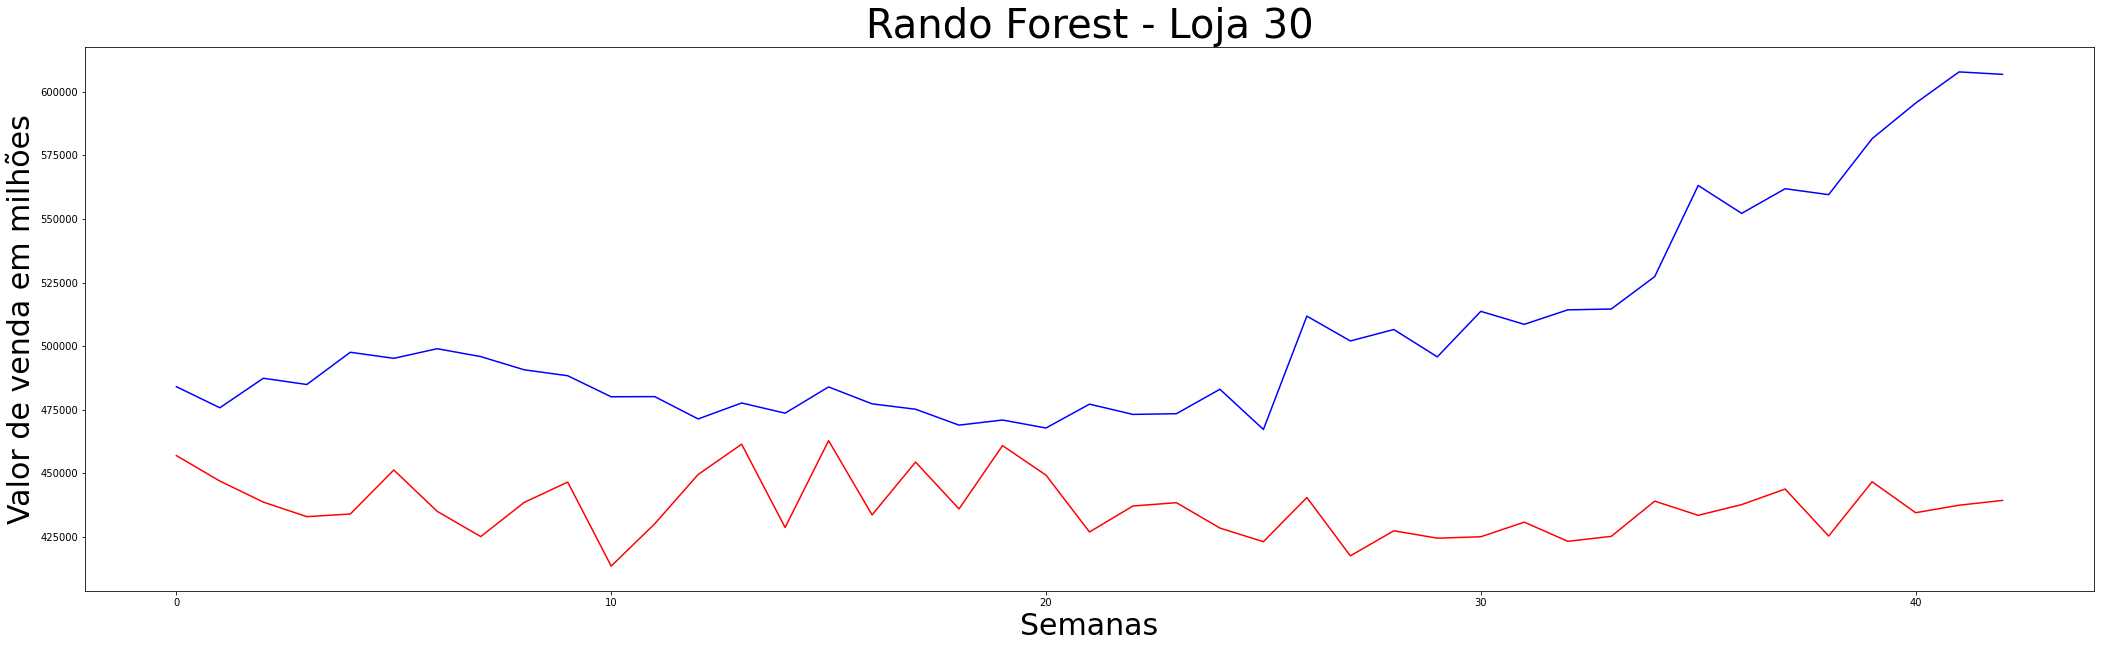

**************************************************
Resultados Loja 31:
256002.58752906977 264975.45574264746


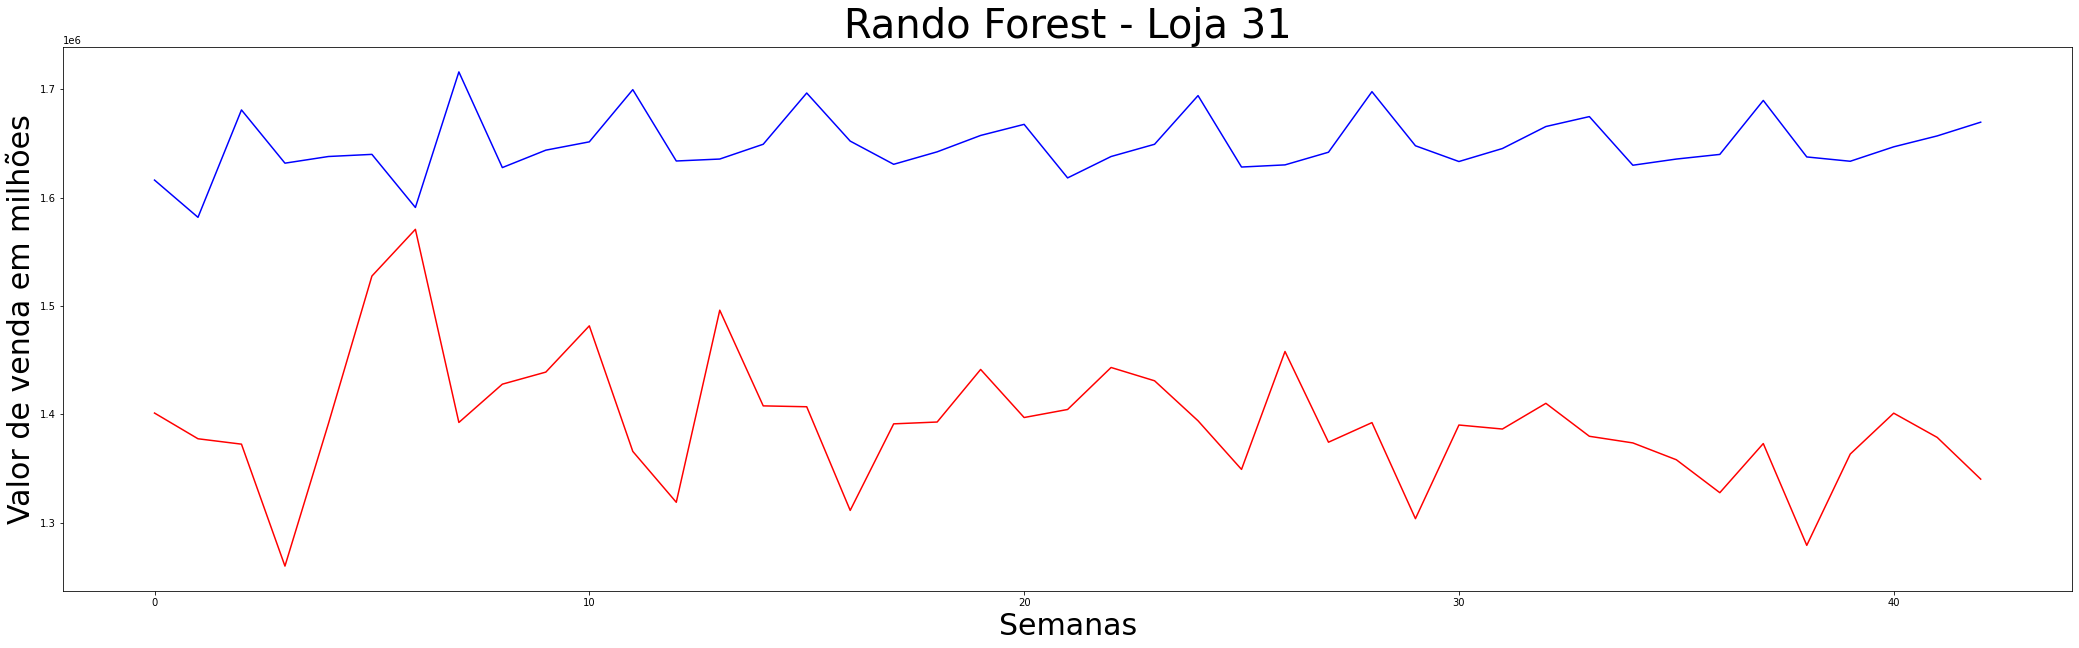

**************************************************
Resultados Loja 32:
209996.58563226744 216706.6528019183


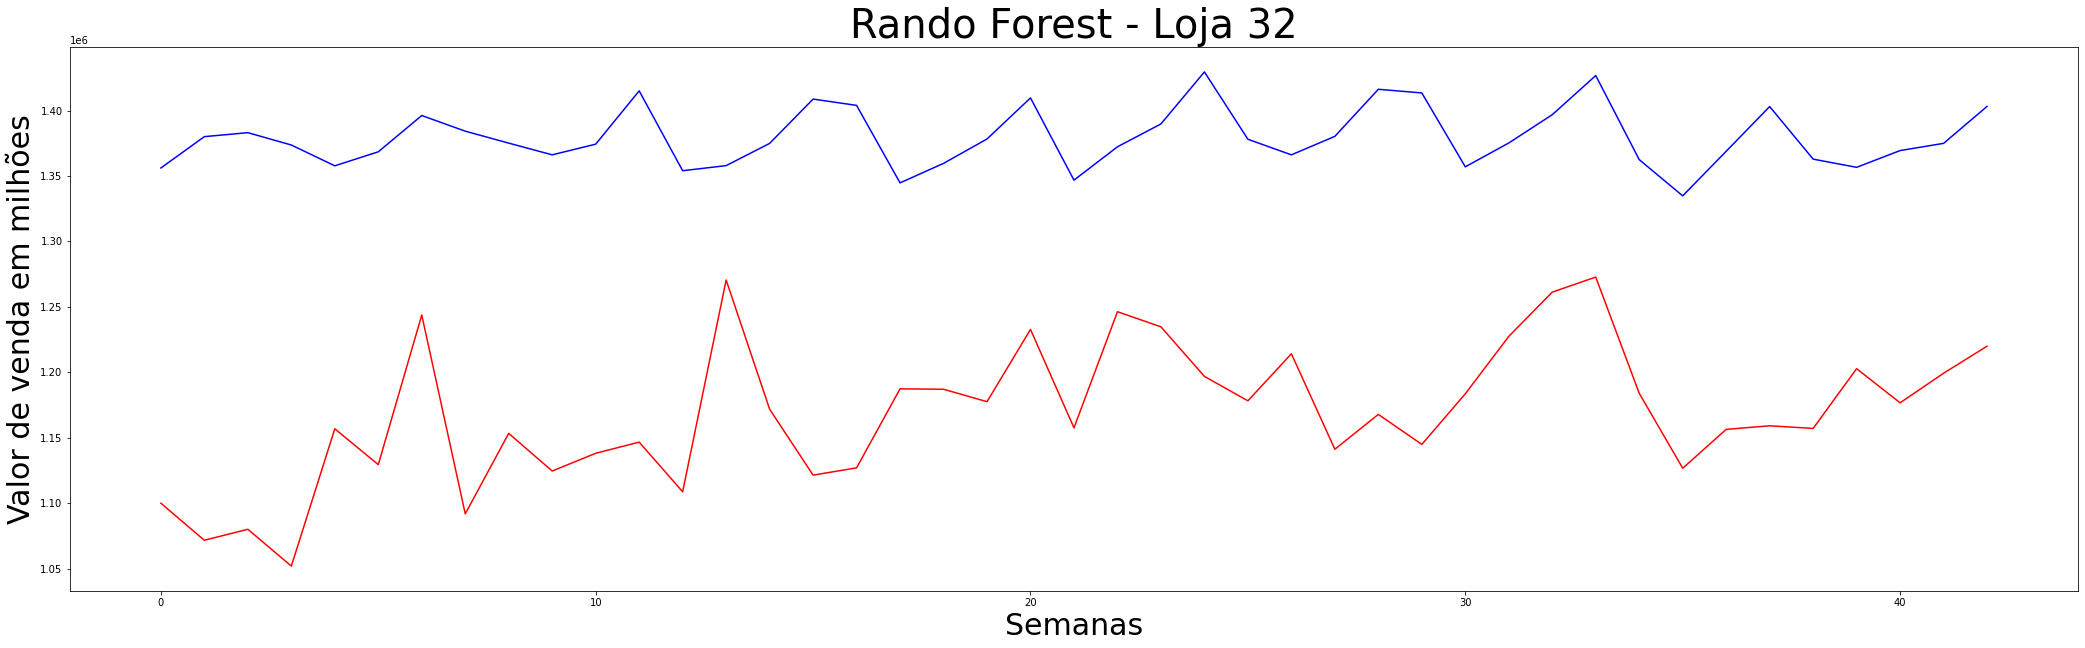

**************************************************
Resultados Loja 33:
32004.12073037791 37996.83523807557


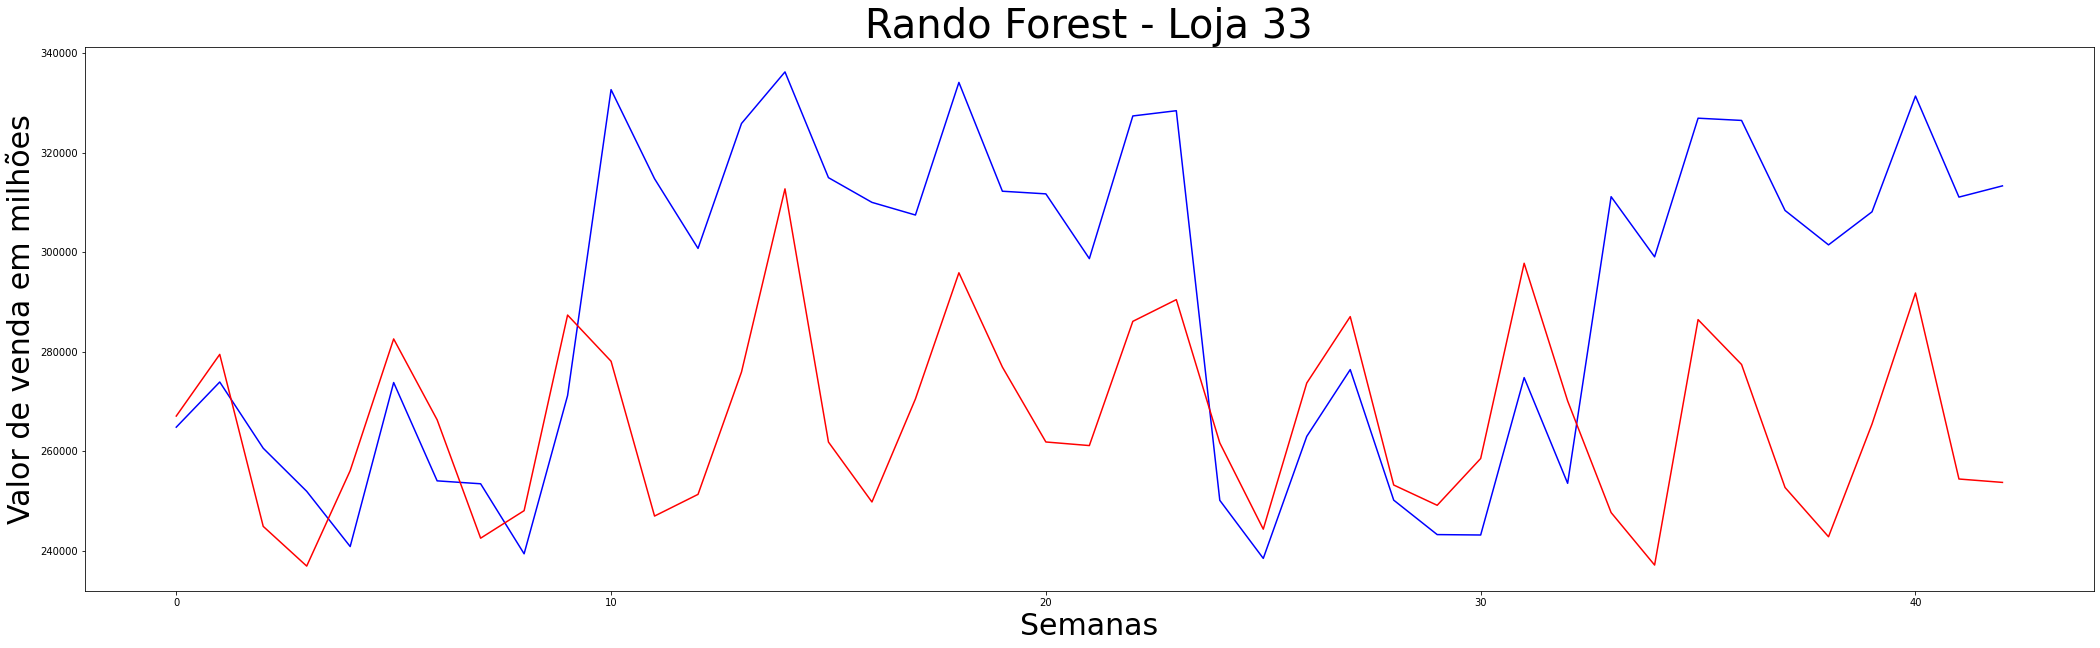

**************************************************
Resultados Loja 34:
26129.736446220926 38073.47826089813


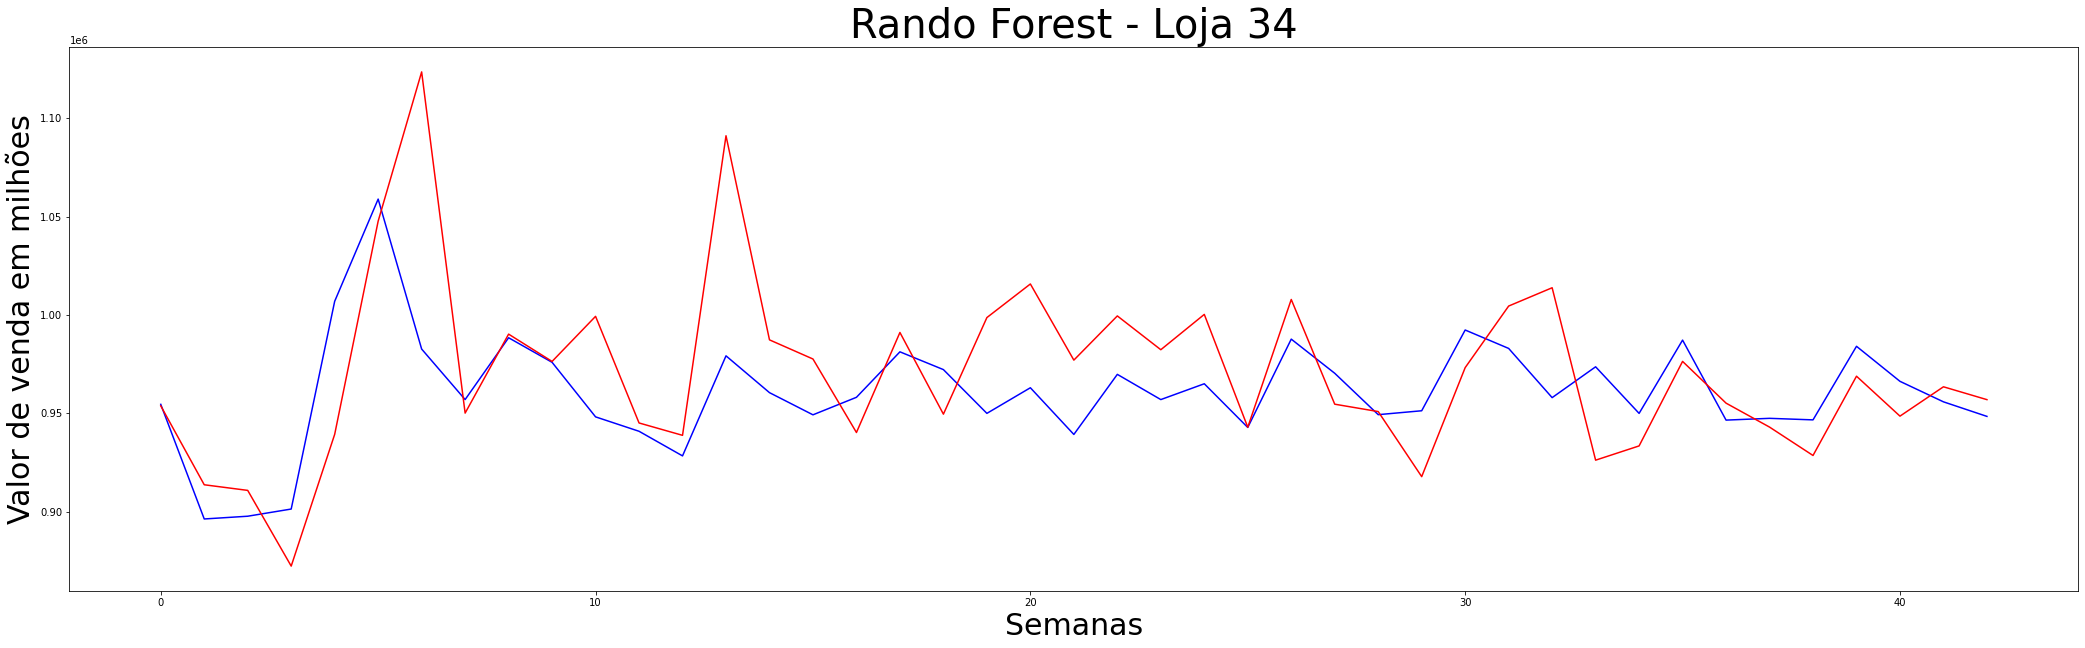

**************************************************
Resultados Loja 35:
47677.782398255826 58344.92267699199


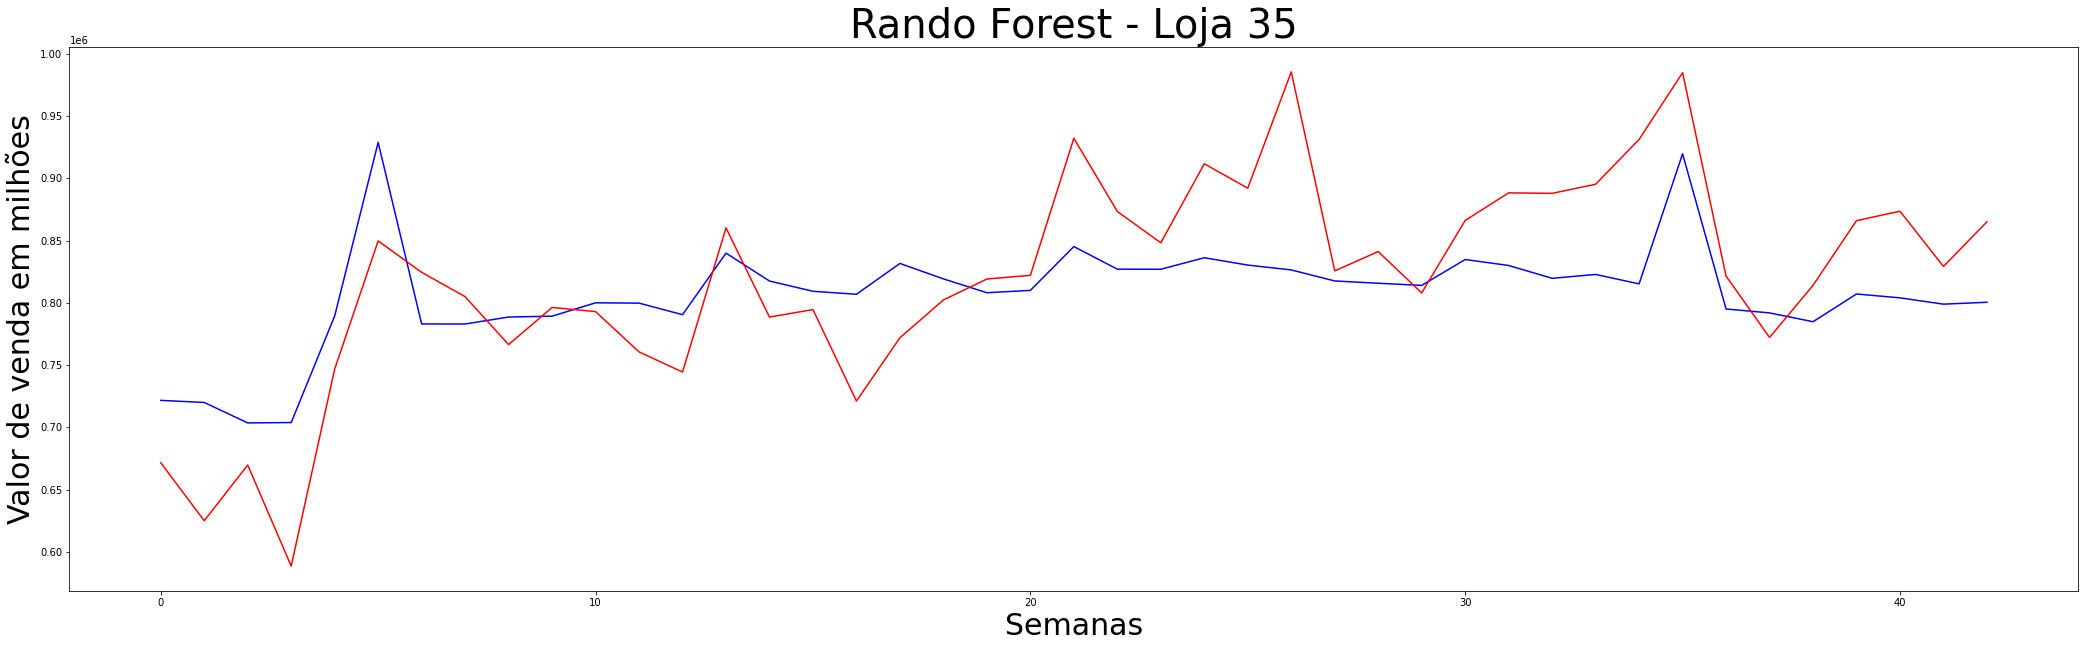

**************************************************
Resultados Loja 36:
122108.91774709304 144872.98392130635


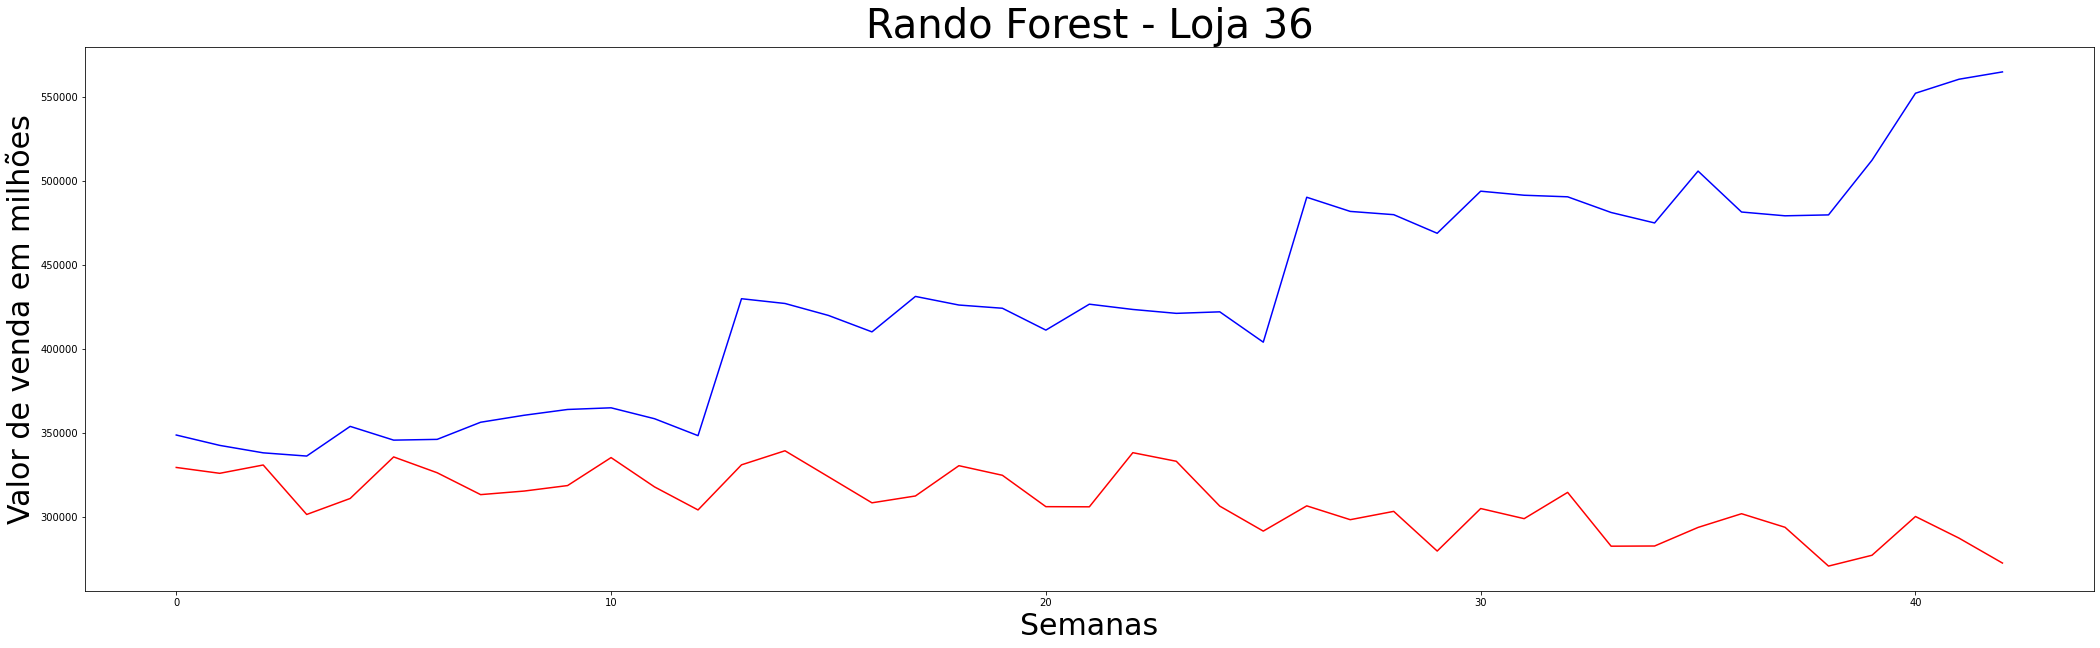

**************************************************
Resultados Loja 37:
24278.379527616282 30746.804537382803


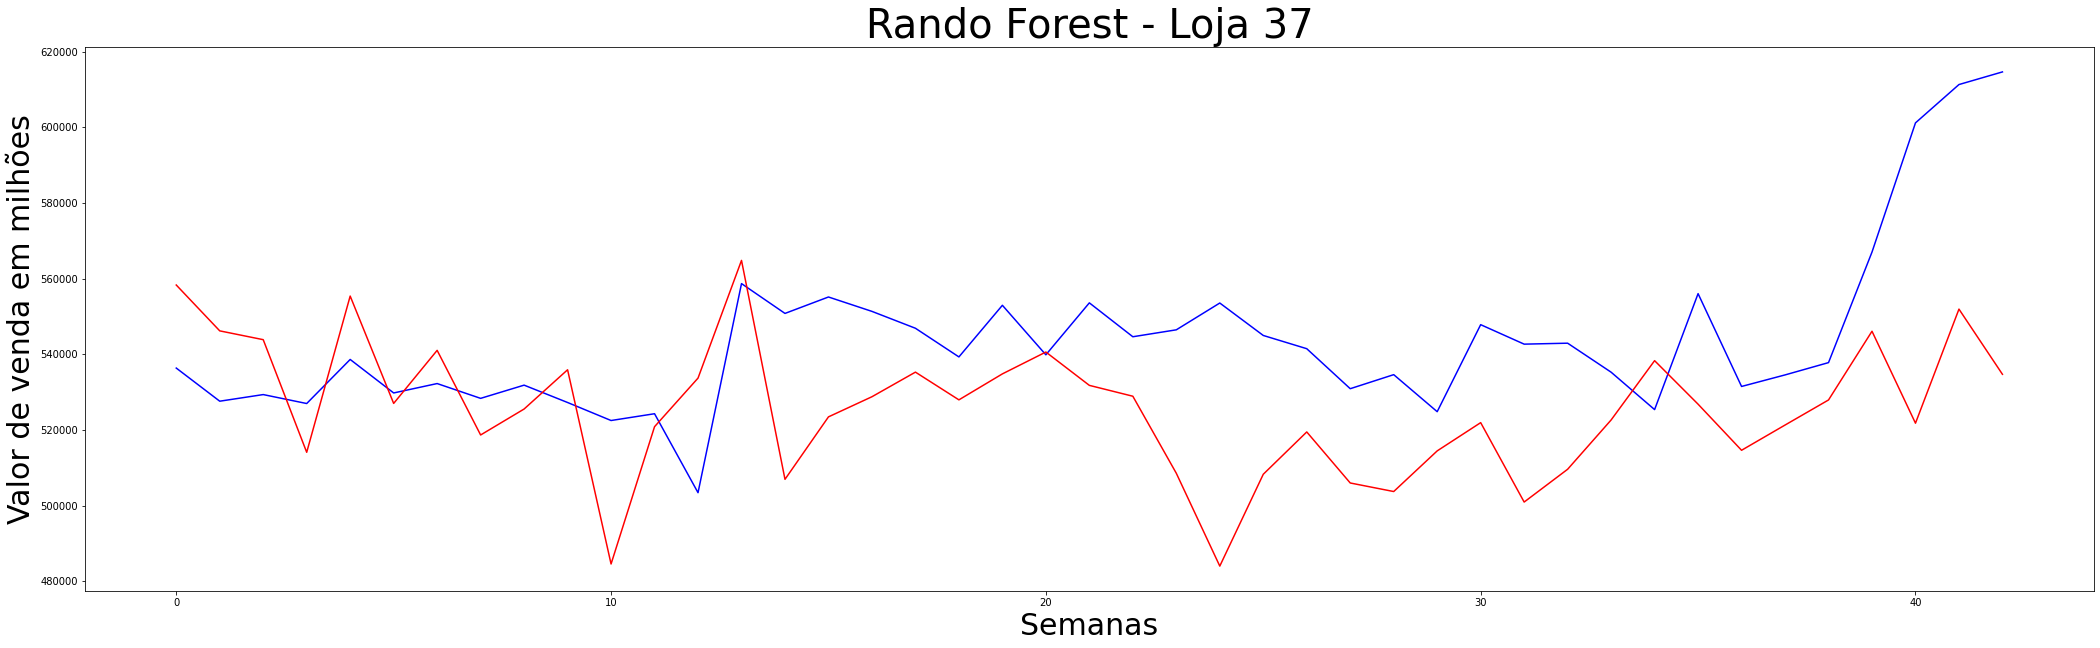

**************************************************
Resultados Loja 38:
19715.533793604653 25154.22313270113


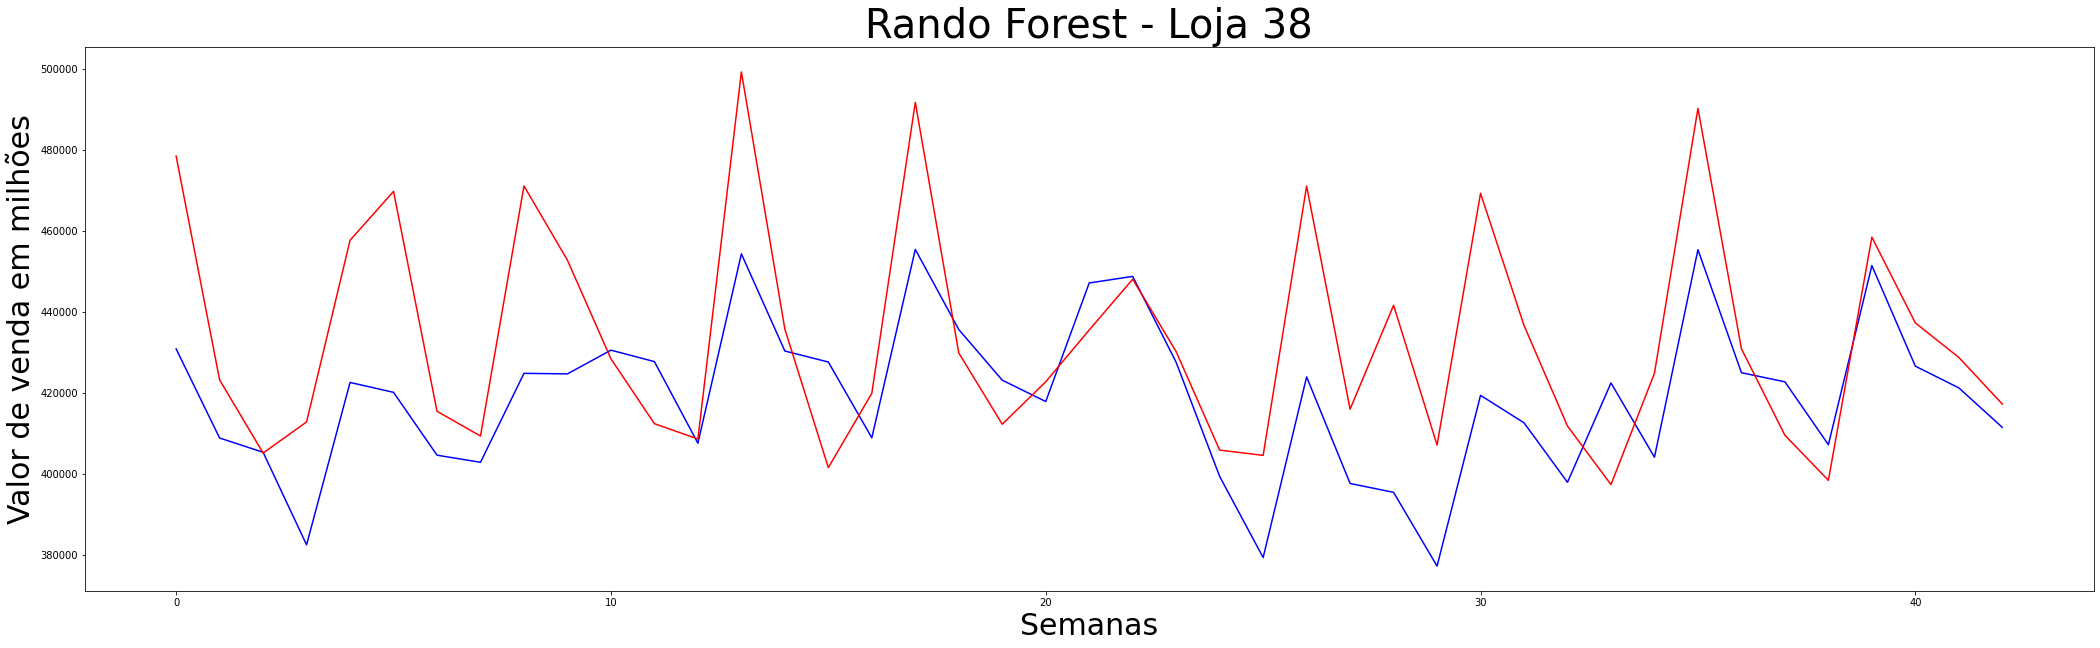

**************************************************
Resultados Loja 39:
413826.66177325574 430993.0046020661


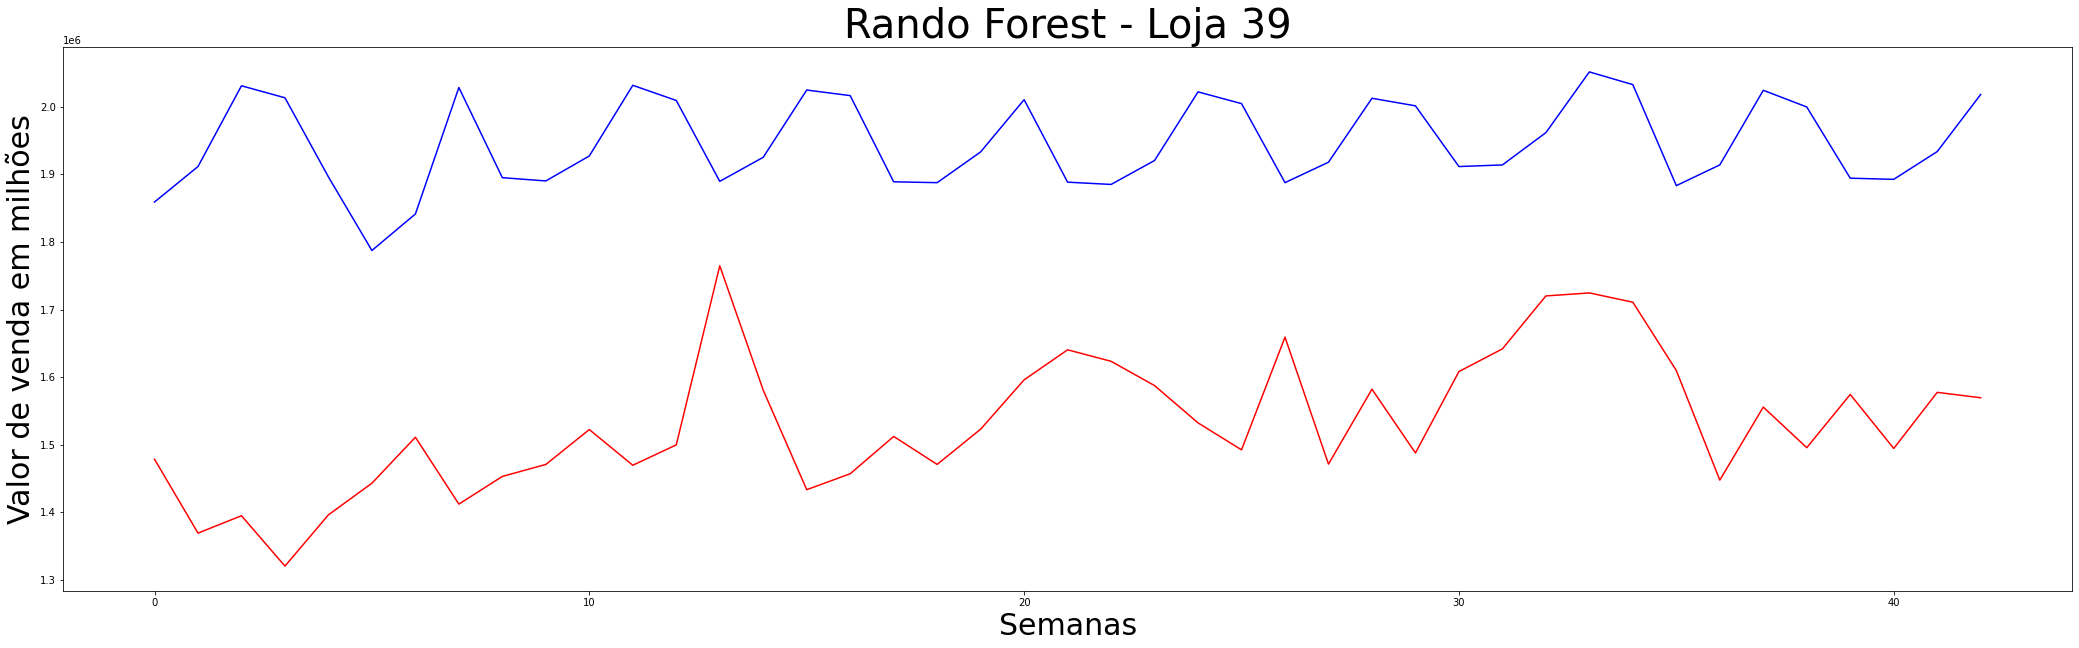

**************************************************
Resultados Loja 40:
60722.97063953488 78092.20534901267


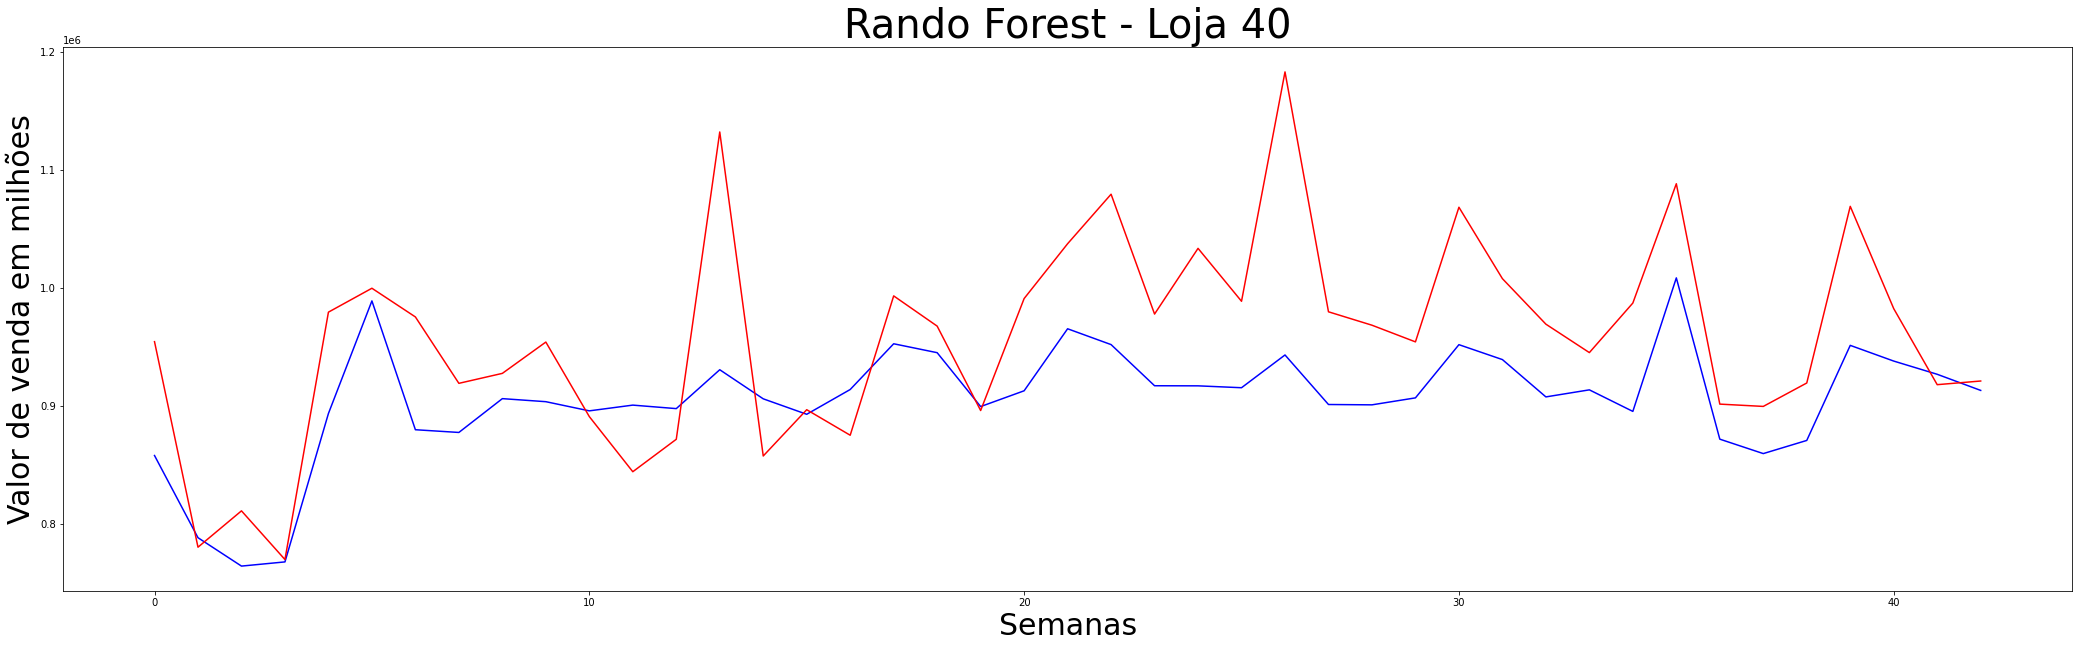

**************************************************
Resultados Loja 41:
192131.436184593 218644.4572829407


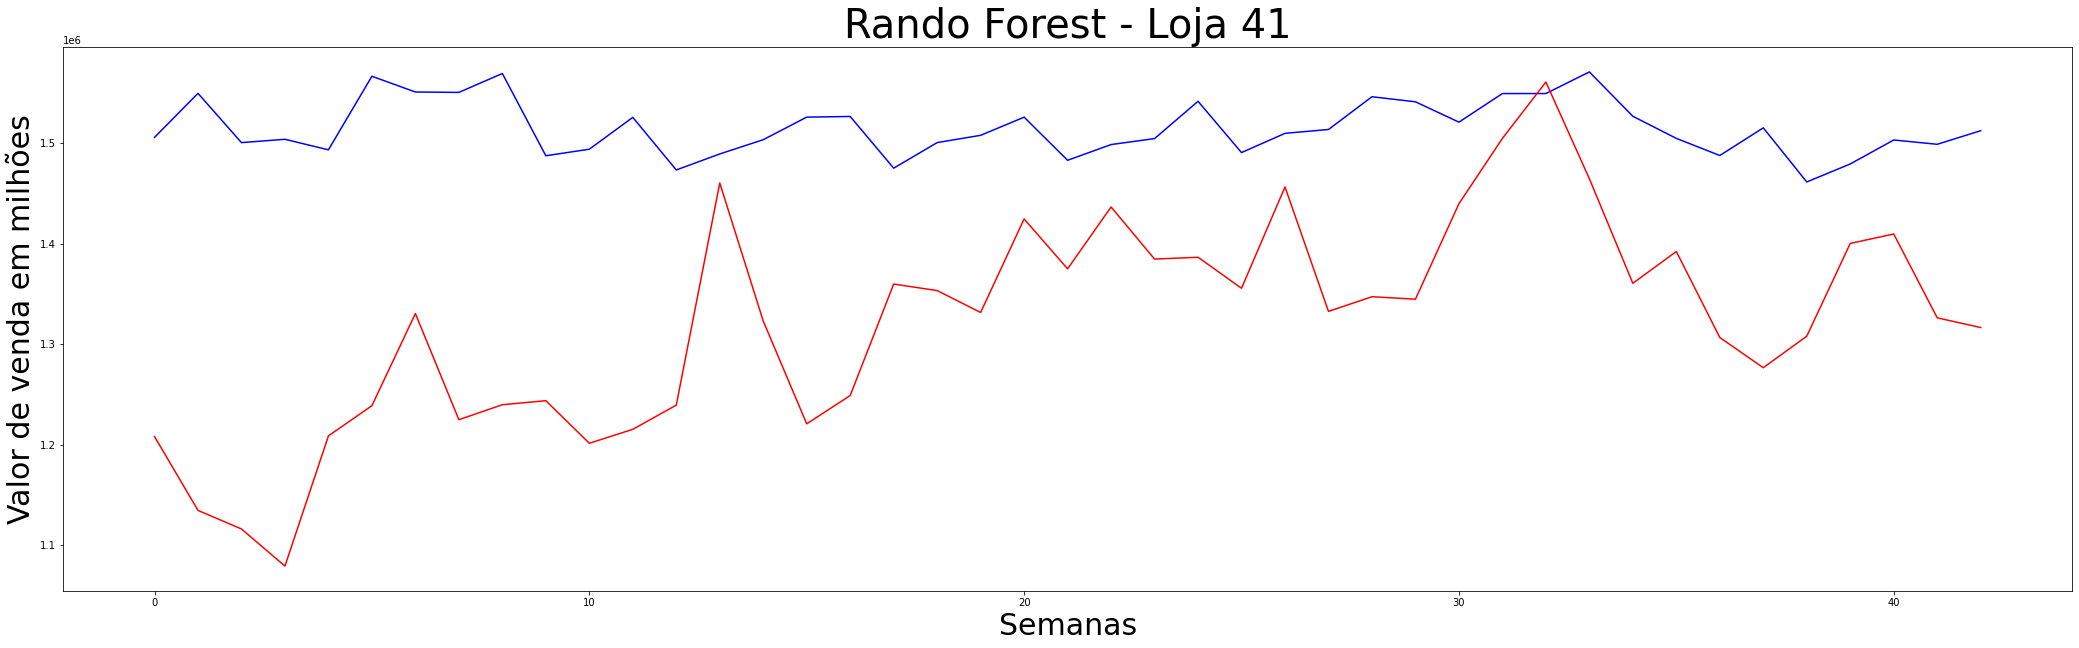

**************************************************
Resultados Loja 42:
37611.60877906975 43439.509932668174


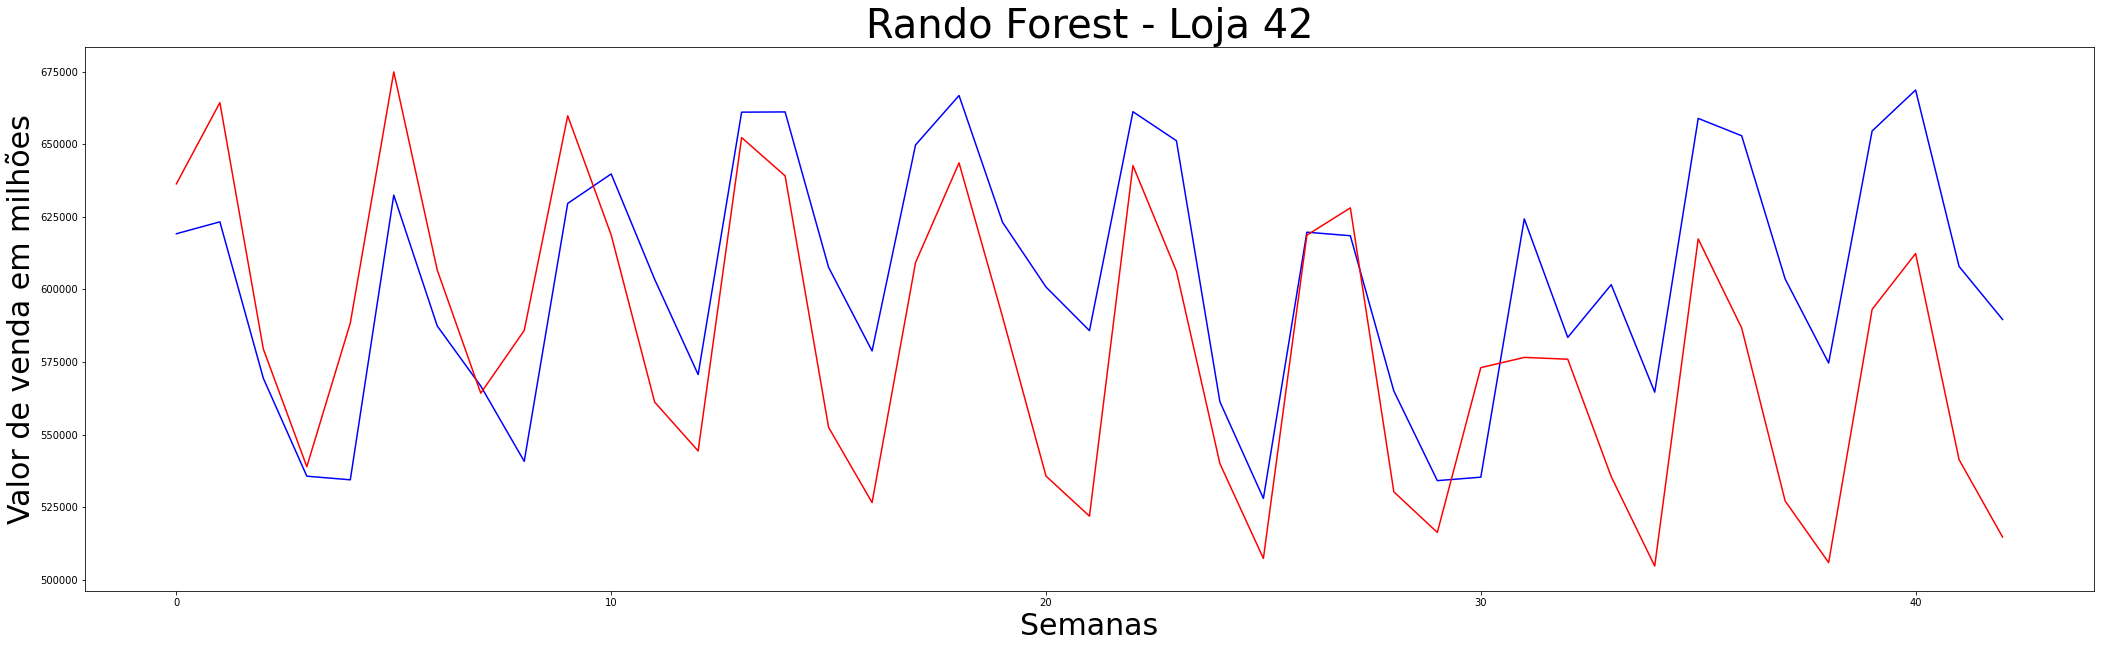

**************************************************
Resultados Loja 43:
59500.06694040696 74872.69792054946


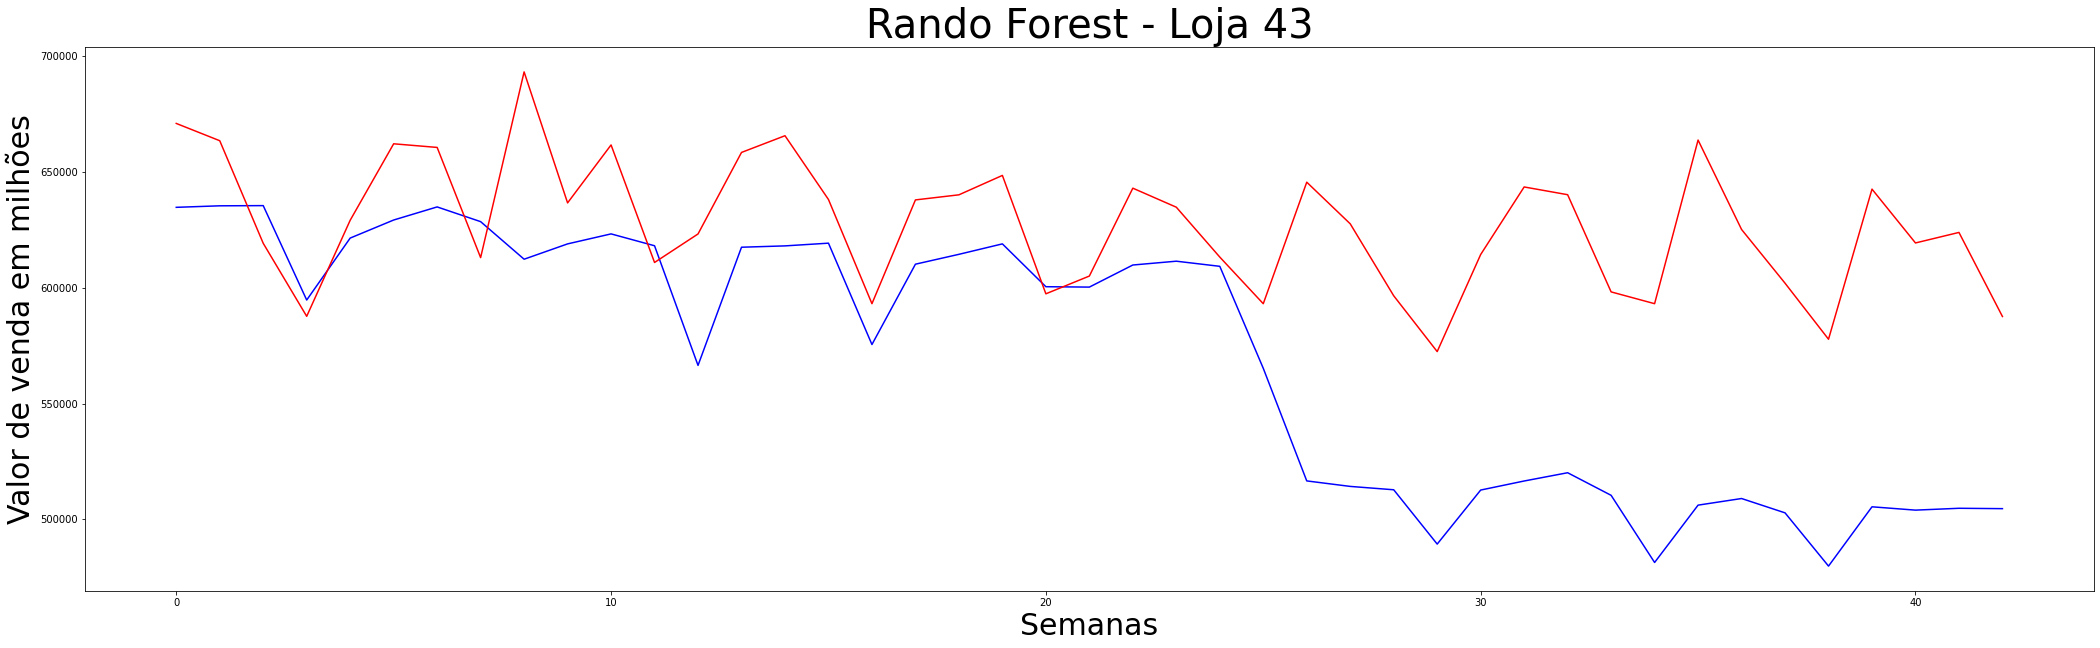

**************************************************
Resultados Loja 44:
30186.843808139532 37655.32020170011


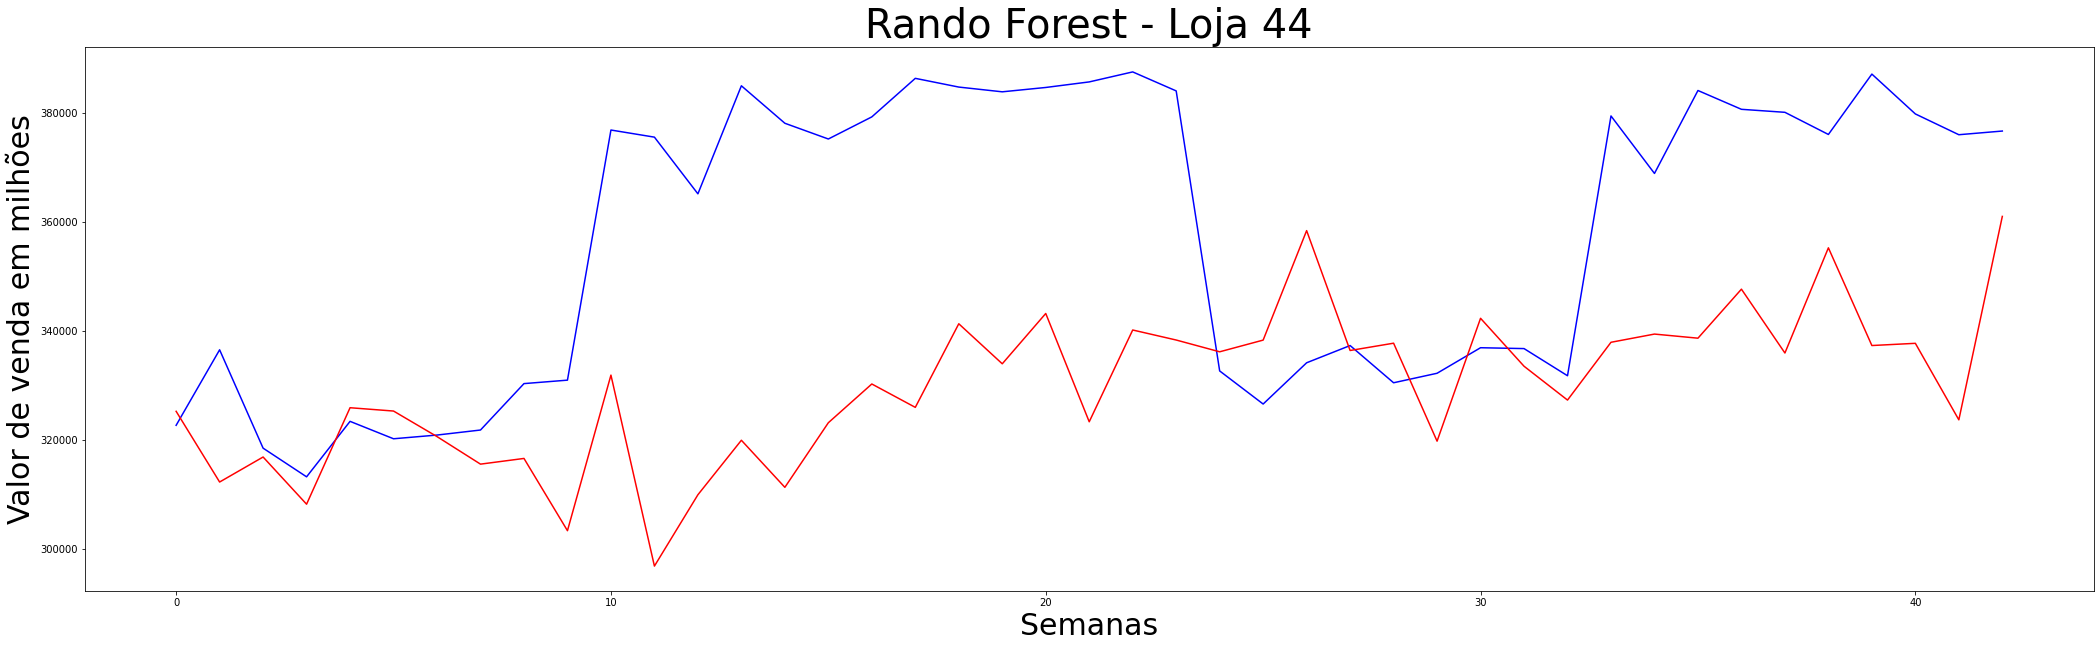

**************************************************
Resultados Loja 45:
108909.46294331395 119683.90455335578


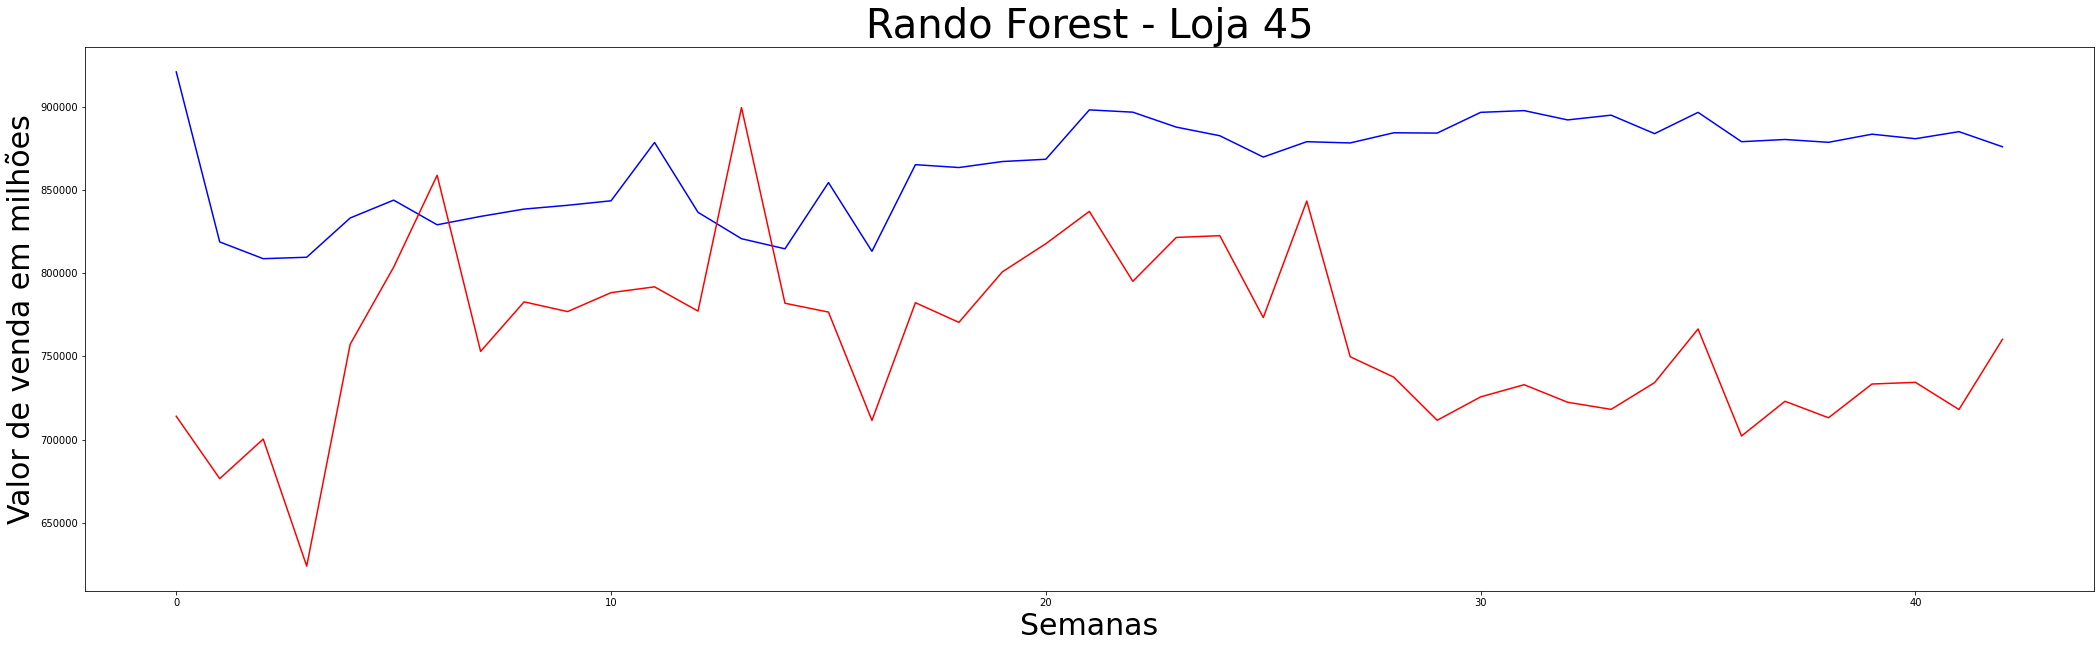

**************************************************


In [97]:
Xy_test = X_test.copy(deep=True)
Xy_test["y"] = y_test.copy()

for i in range(1, 46):
  X_loja = Xy_test.where(Xy_test["Store_" + str(i)] == 1).dropna()
  y_loja = X_loja["y"]
  X_loja = X_loja.drop(["y"], axis=1)

  predictions_loja = rf.predict(X_loja)

  print("Resultados Loja {}:".format(i))
  print(mean_absolute_error(y_loja, predictions_loja), np.sqrt(mean_squared_error(y_loja, predictions_loja)))
  
  plt.figure(figsize = (36, 10)) 
  plt.plot(range(len(predictions_loja)), predictions_loja, 'b')
  plt.plot(range(len(predictions_loja)), y_loja, 'r')
  plt.title("Rando Forest - Loja {}".format(i), fontsize=40)
  plt.xlabel("Semanas", fontsize=30)
  plt.ylabel("Valor de venda em milhões", fontsize=30)

  plt.show()
  
  print(50*"*")
